In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import warnings
warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

In [2]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import TemporalFusionTransformer, Baseline, TimeSeriesDataSet
from pytorch_forecasting.metrics import SMAPE
from pytorch_forecasting.data.encoders import NaNLabelEncoder, GroupNormalizer
import pytorch_forecasting

# imports for training
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
# import dataset, network to train and metric to optimize
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss
from lightning.pytorch.tuner import Tuner
import traceback

In [3]:
# Load data
data = pd.read_csv('/Users/zhezhengren/Desktop/NeuroPrior_AI/Model_Competion/EEG/Data_Processing/Data_Epoch_Range/Data_Epoch.csv')

# Create a list of channel names
channel_names = ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'CZ', 'C4', 
                 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'PZ', 'P4', 'P8', 'PO9', 'O1', 'OZ', 
                 'O2', 'PO10', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FT9', 'FT7', 'FC3', 'FC4', 'FT8', 
                 'FT10', 'C5', 'C1', 'C2', 'C6', 'TP7', 'CP3', 'CPZ', 'CP4', 'TP8', 'P5', 'P1', 'P2', 'P6', 'PO7', 
                 'PO3', 'POZ', 'PO4', 'PO8']

if 'Unnamed: 0.1' in data.columns:
    data = data.drop(columns=['Unnamed: 0.1'])

if 'Unnamed: 0' in data.columns:
    data = data.drop(columns=['Unnamed: 0'])

print(data.columns)

non_numeric_columns = data.select_dtypes(include=['object']).columns
print(non_numeric_columns)

data['FileName'] = data['FileName'].astype(str)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['Event Name'] = le.fit_transform(data['Event Name'].astype(str)).astype(float)

for channel in channel_names:
    data[channel] = data[channel].astype(float)

Index(['FileName', 'Event Name', 'Time_Point', 'FP1', 'FP2', 'F7', 'F3', 'FZ',
       'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'CZ', 'C4', 'T8',
       'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'PZ', 'P4', 'P8',
       'PO9', 'O1', 'OZ', 'O2', 'PO10', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1',
       'F2', 'F6', 'FT9', 'FT7', 'FC3', 'FC4', 'FT8', 'FT10', 'C5', 'C1', 'C2',
       'C6', 'TP7', 'CP3', 'CPZ', 'CP4', 'TP8', 'P5', 'P1', 'P2', 'P6', 'PO7',
       'PO3', 'POZ', 'PO4', 'PO8'],
      dtype='object')
Index(['FileName', 'Event Name'], dtype='object')


In [4]:
data.describe()

,Event Name,Time_Point,FP1,FP2,F7,F3,FZ,F4,F8,FC5,...,TP8,P5,P1,P2,P6,PO7,PO3,POZ,PO4,PO8
count,8.935034e+06,8.935034e+06,8.935034e+06,8.935034e+06,8.935034e+06,8.935034e+06,8.935034e+06,8.935034e+06,8.935034e+06,8.935034e+06,...,8.935034e+06,8.935034e+06,8.935034e+06,8.935034e+06,8.935034e+06,8.935034e+06,8.935034e+06,8.935034e+06,8.935034e+06,8.935034e+06
mean,5.128407e+00,7.045445e+04,-3.115906e-07,-6.782022e-07,2.448467e-07,3.570915e-08,-1.229705e-08,8.840254e-09,-6.684581e-08,1.209507e-07,...,1.953541e-07,4.961062e-08,5.771616e-08,5.716799e-08,6.645271e-08,1.079891e-07,3.829087e-08,7.874696e-08,6.342398e-08,2.177812e-08
std,1.666626e+00,4.155020e+04,5.320359e-05,6.908033e-05,2.793612e-05,1.776322e-05,1.249871e-05,1.618682e-05,2.725982e-05,2.250818e-05,...,2.849350e-05,1.988838e-05,1.877270e-05,1.972079e-05,2.155110e-05,2.278891e-05,2.050404e-05,2.035508e-05,2.245609e-05,2.840964e-05
min,0.000000e+00,0.000000e+00,-1.168954e-03,-1.979760e-03,-5.560171e-04,-4.956512e-04,-6.302431e-04,-3.024491e-04,-5.016216e-04,-6.428357e-04,...,-3.070598e-03,-3.250377e-03,-3.331361e-03,-3.371235e-03,-3.236876e-03,-3.187349e-03,-3.151214e-03,-3.279416e-03,-3.394646e-03,-3.167204e-03
25%,6.000000e+00,3.490200e+04,-1.463787e-05,-1.450618e-05,-1.152337e-05,-8.875036e-06,-6.148119e-06,-8.862103e-06,-1.182000e-05,-9.229579e-06,...,-1.133166e-05,-1.014979e-05,-9.605515e-06,-1.053415e-05,-1.074530e-05,-1.159963e-05,-1.063858e-05,-1.046363e-05,-1.135537e-05,-1.374761e-05
50%,6.000000e+00,6.980400e+04,-2.277831e-06,-2.407344e-06,-1.257492e-07,-2.079940e-07,-1.828231e-07,-2.127272e-07,-2.077187e-07,9.016666e-08,...,2.309897e-07,1.795632e-07,2.227641e-07,2.365517e-07,2.363301e-07,2.701590e-07,2.020529e-07,2.768342e-07,1.679846e-07,2.472149e-07
75%,6.000000e+00,1.047070e+05,1.021063e-05,9.823225e-06,1.128663e-05,8.746018e-06,5.844003e-06,8.618712e-06,1.152293e-05,9.502170e-06,...,1.169710e-05,1.043431e-05,9.865727e-06,1.084657e-05,1.103895e-05,1.203252e-05,1.099449e-05,1.084293e-05,1.164706e-05,1.412200e-05
max,6.000000e+00,2.025340e+05,2.591308e-03,3.034607e-03,8.859959e-04,2.211873e-04,1.084445e-04,2.879843e-04,5.806930e-04,6.281690e-04,...,5.986769e-03,5.988817e-03,5.902428e-03,5.898313e-03,5.993468e-03,6.006965e-03,6.043596e-03,6.008004e-03,5.937879e-03,6.023455e-03


In [5]:
max_prediction_length = 500
max_encoder_length = 1
#training_cutoff = data["Time_Point"].max()- max_prediction_length
training_cutoff = data["Time_Point"].max()*0.8

training = TimeSeriesDataSet(
    data[lambda x: x.Time_Point <= training_cutoff],
    time_idx="Time_Point",
    target="Event Name",
    group_ids=["FileName"],
    min_encoder_length=max(1,max_encoder_length // 2),  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],
    variable_groups={},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["Time_Point"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=channel_names,
    target_normalizer=GroupNormalizer(
        groups=["FileName"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation dataset using the same normalization techniques as for the training dataset
validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training.index.time.max() + 1, stop_randomization=True)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
# validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=2)

print(f"Training dataset length: {len(training)}")
print(f"Validation dataset length: {len(validation)}")

for i, batch in enumerate(val_dataloader):
    print(f"Batch {i} type: {type(batch)}")
    print(f"Batch {i} length: {len(batch)}")
    
    # Print the shapes of all elements in the batch, if they are tensors
    for j, element in enumerate(batch):
        if isinstance(element, torch.Tensor):
            print(f"Element {j} size: {element.size()}")

    # Break the loop after examining the first few batches
    if i >= 2:
        break

for i, batch in enumerate(val_dataloader):
    inputs, targets = batch  # unpack the tuple into inputs and targets
    
    print(f"Batch {i} inputs keys: {inputs.keys()}")
    for key in inputs:
        if isinstance(inputs[key], torch.Tensor):
            print(f"inputs['{key}'] size: {inputs[key].size()}")
    
    print(f"Batch {i} targets type: {type(targets)}")
    for j, element in enumerate(targets):
        print(f"targets[{j}] type: {type(element)}")
        if isinstance(element, torch.Tensor):
            print(f"targets[{j}] size: {element.size()}")

    # Break the loop after examining the first few batches
    if i >= 2:
        break

Training dataset length: 8904153
Validation dataset length: 65253
Batch 0 type: <class 'tuple'>
Batch 0 length: 2
Batch 1 type: <class 'tuple'>
Batch 1 length: 2
Batch 2 type: <class 'tuple'>
Batch 2 length: 2
Batch 0 inputs keys: dict_keys(['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale'])
inputs['encoder_cat'] size: torch.Size([1280, 1, 0])
inputs['encoder_cont'] size: torch.Size([1280, 1, 69])
inputs['encoder_target'] size: torch.Size([1280, 1])
inputs['encoder_lengths'] size: torch.Size([1280])
inputs['decoder_cat'] size: torch.Size([1280, 500, 0])
inputs['decoder_cont'] size: torch.Size([1280, 500, 69])
inputs['decoder_target'] size: torch.Size([1280, 500])
inputs['decoder_lengths'] size: torch.Size([1280])
inputs['decoder_time_idx'] size: torch.Size([1280, 500])
inputs['groups'] size: torch.Size([1280, 1])
inputs['target_scale'] size: torch.Size([12

In [6]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=1, verbose=False, mode="min")

# configure network and trainer
pl.seed_everything(42)
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=100, # It should be 100
    accelerator="cpu",  # run on CPU, if on multiple GPUs, use strategy="ddp"
    #strategy="ddp",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # 50 batches per epoch
    callbacks=[lr_logger, early_stop_callback],
    logger=TensorBoardLogger("lightning_logs")
)

# define network to train - the architecture is mostly inferred from the dataset, so that only a few hyperparameters have to be set by the user
tft = TemporalFusionTransformer.from_dataset(
    # dataset
    training,
    # architecture hyperparameters
    hidden_size=32,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=16,
    # loss metric to optimize
    loss=QuantileLoss(),
    # logging frequency
    log_interval=2,
    # optimizer parameters
    learning_rate=0.03,
    optimizer="Ranger",
    reduce_on_plateau_patience=4
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 223.4k


Finding best initial lr: 100%|████████████████| 100/100 [16:13<00:00,  9.74s/it]
Learning rate set to 0.01908894180530999
Restoring states from the checkpoint path at /Users/zhezhengren/Desktop/NeuroPrior_AI/.lr_find_52e4d2f9-8d14-44c6-b4cd-61a57052c2b5.ckpt
Restored all states from the checkpoint at /Users/zhezhengren/Desktop/NeuroPrior_AI/.lr_find_52e4d2f9-8d14-44c6-b4cd-61a57052c2b5.ckpt


suggested learning rate: 0.01908894180530999


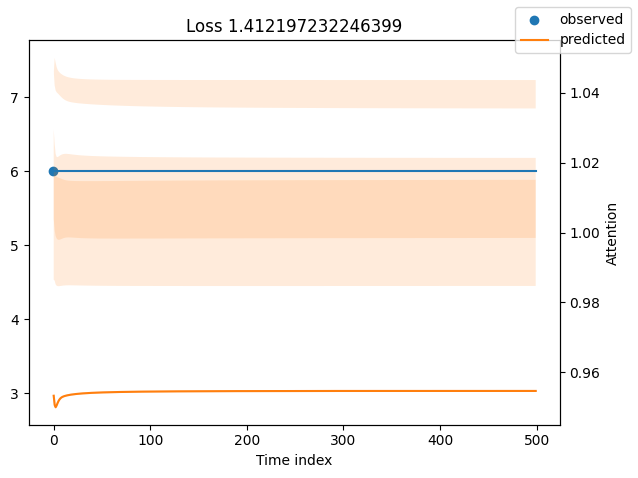

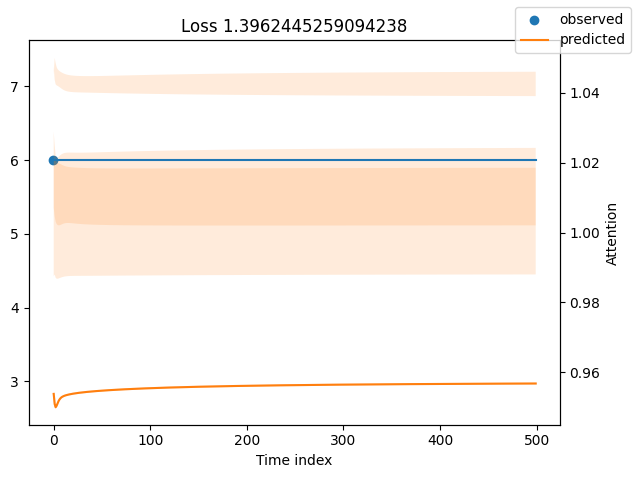

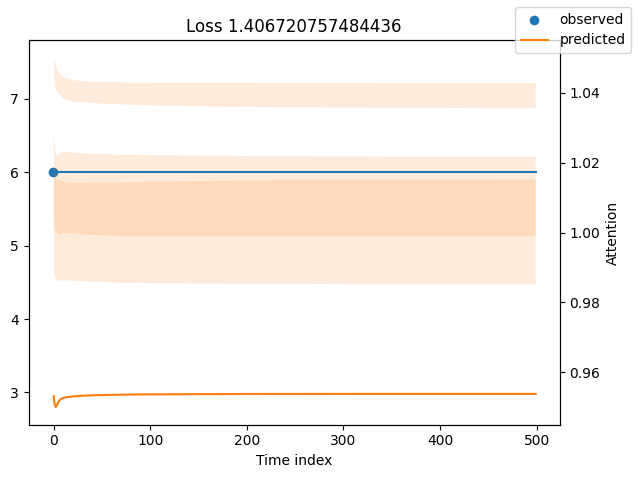

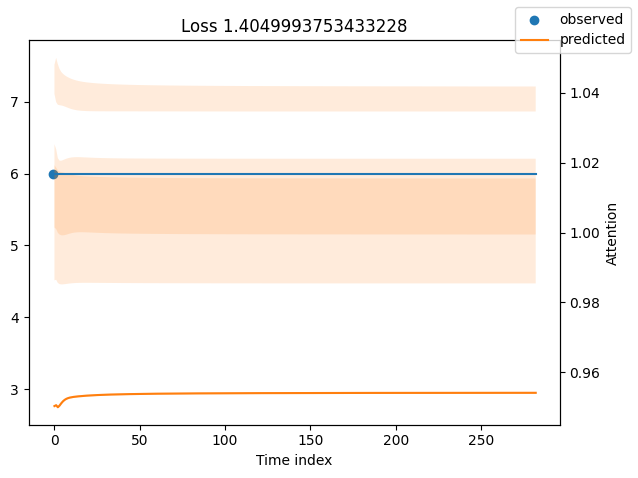

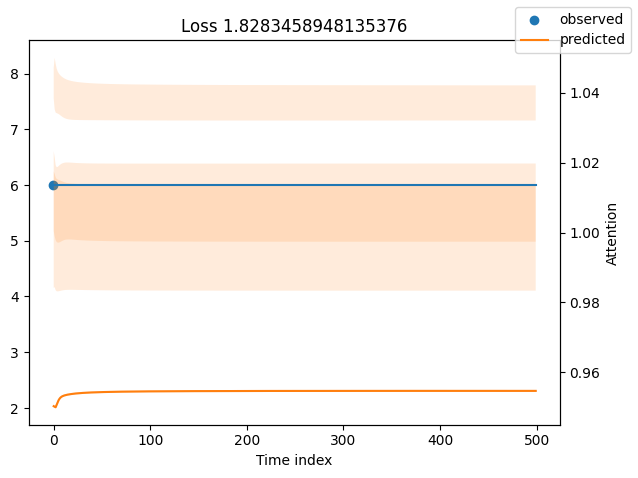

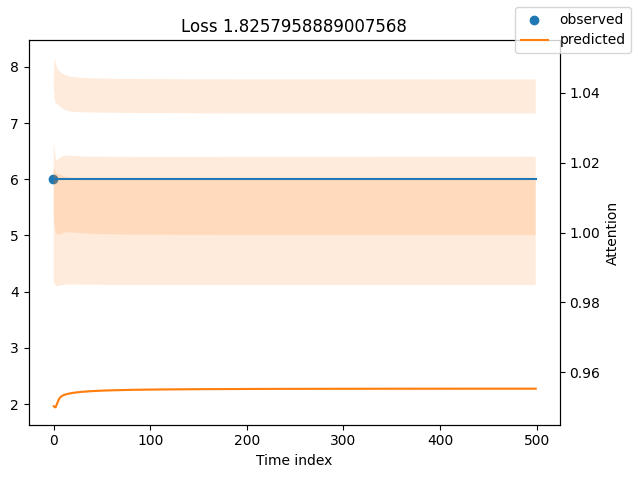

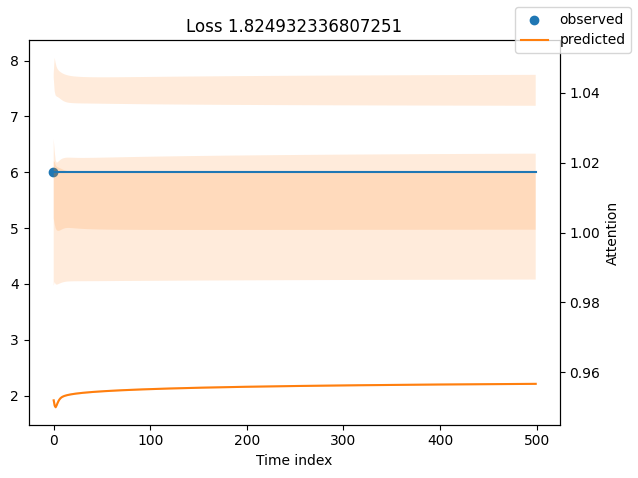

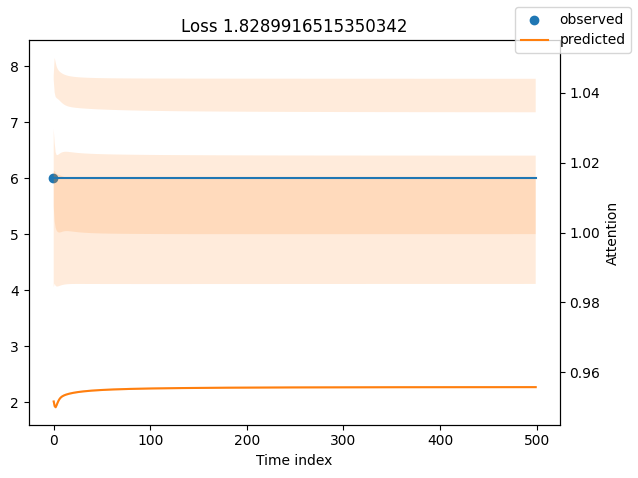

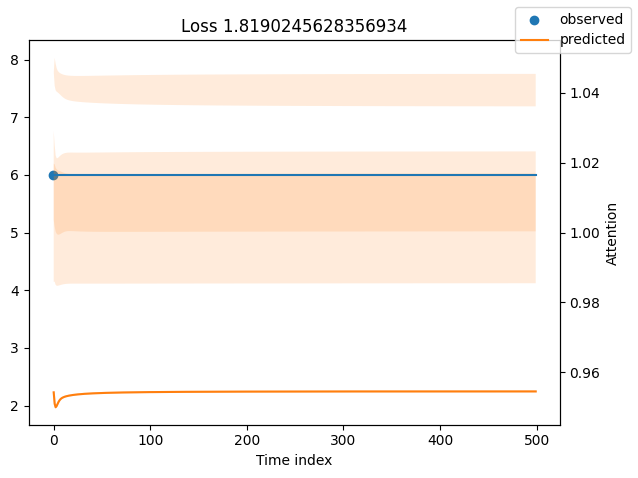

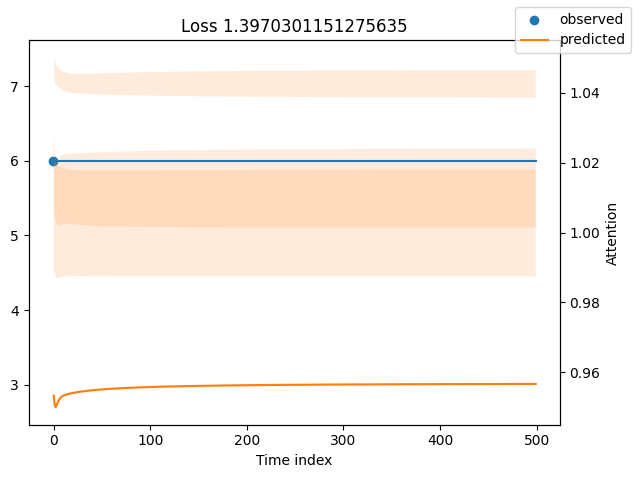

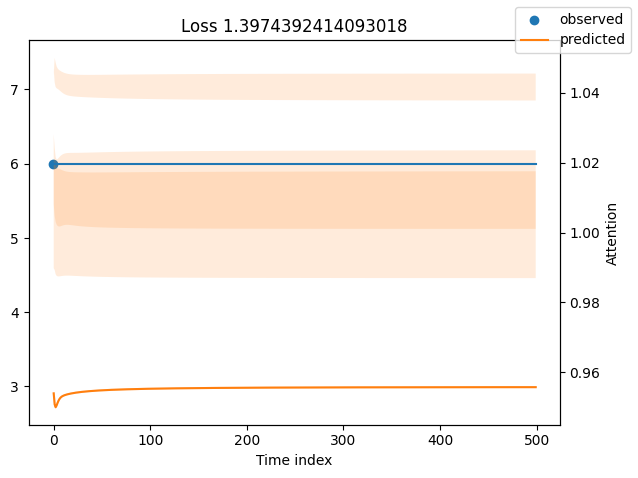

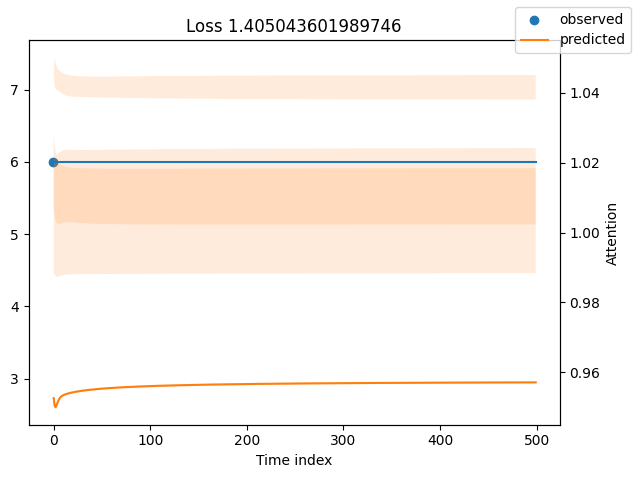

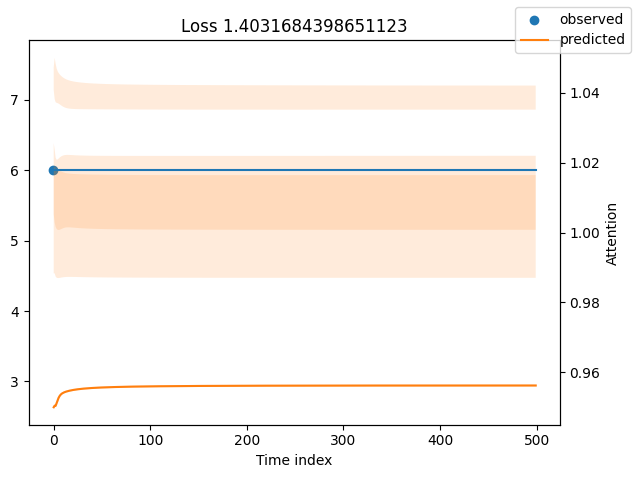

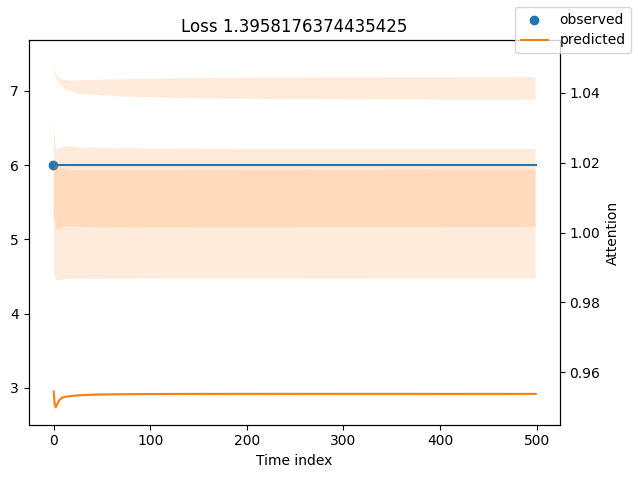

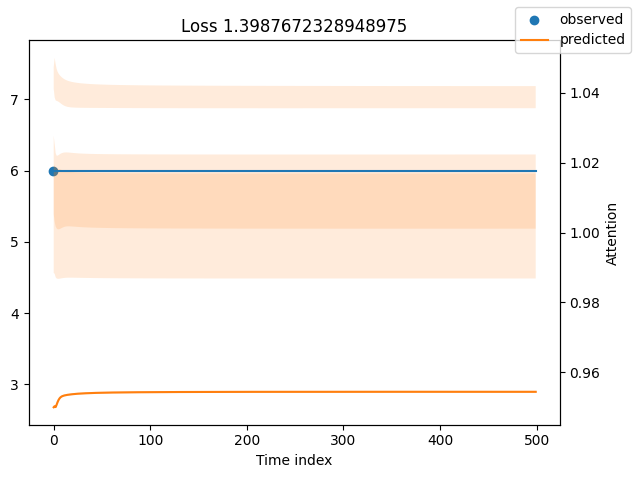

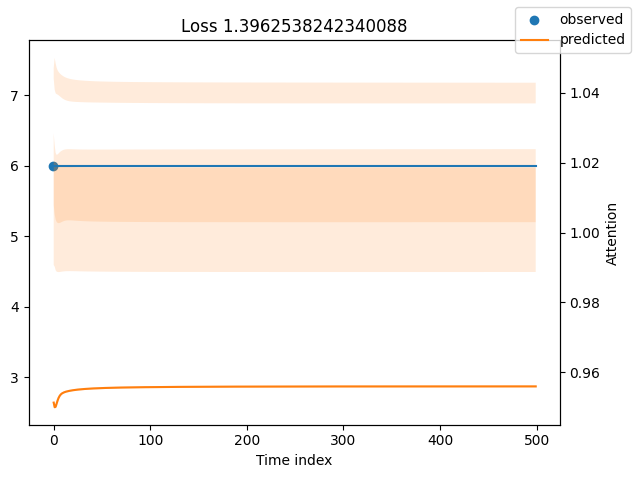

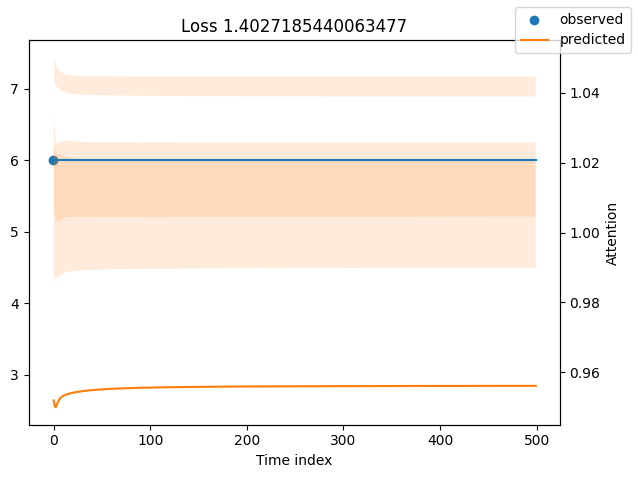

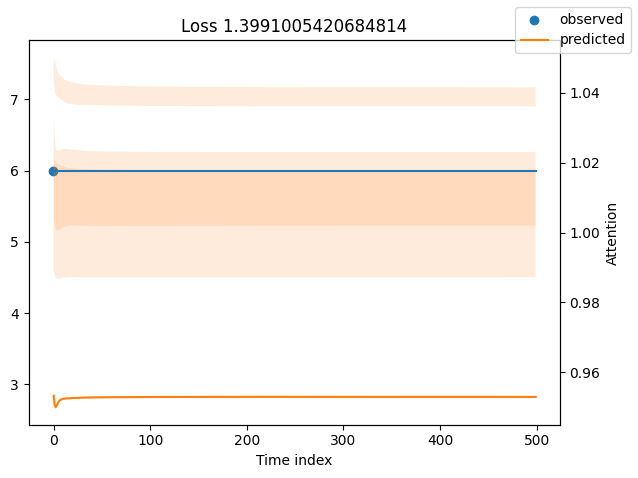

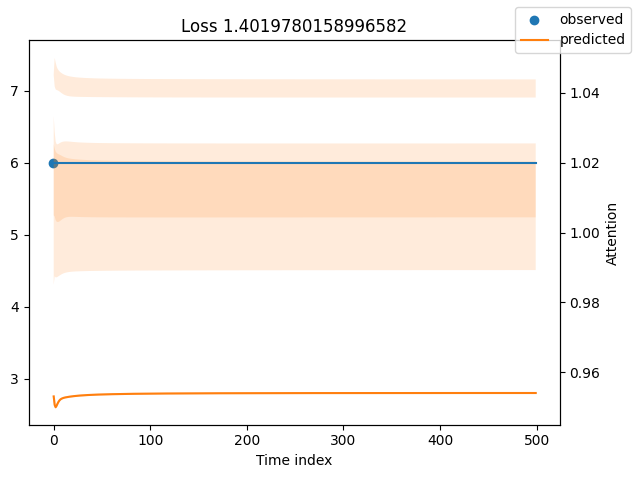

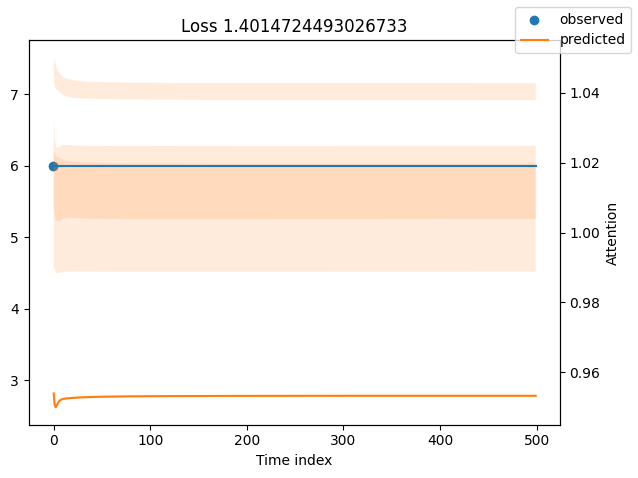

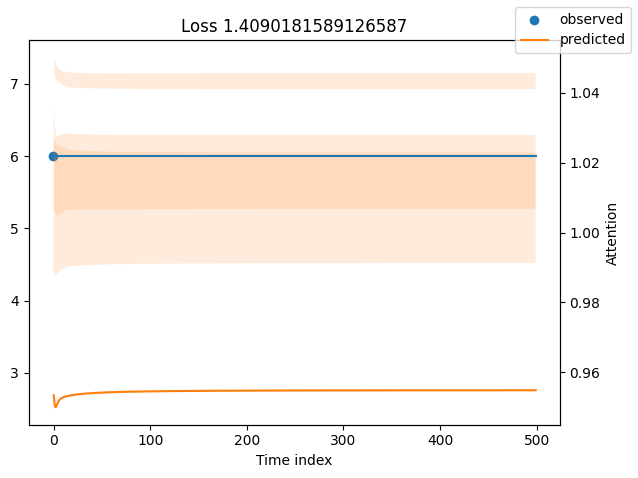

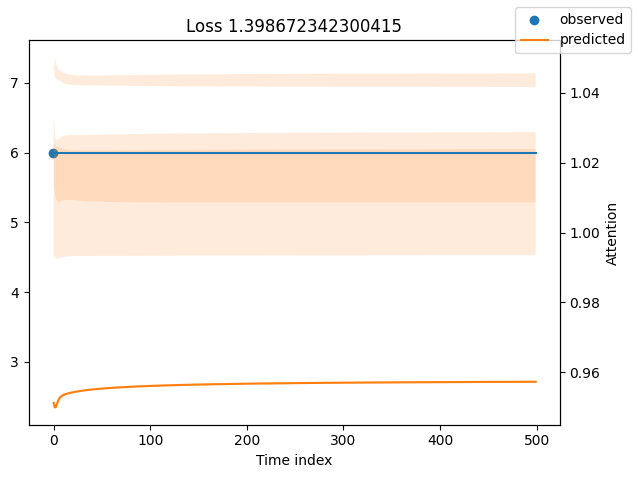

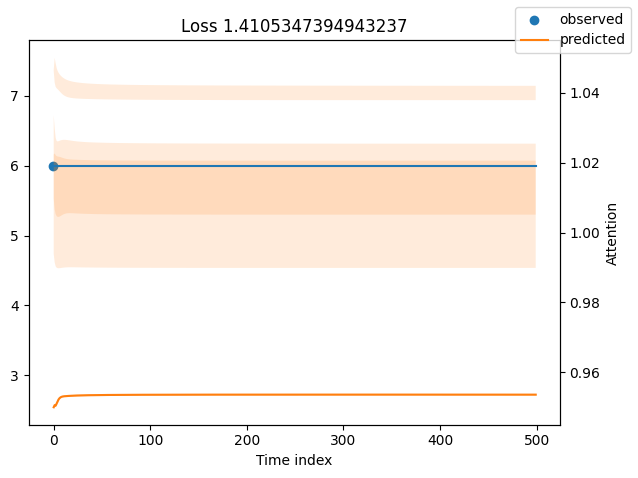

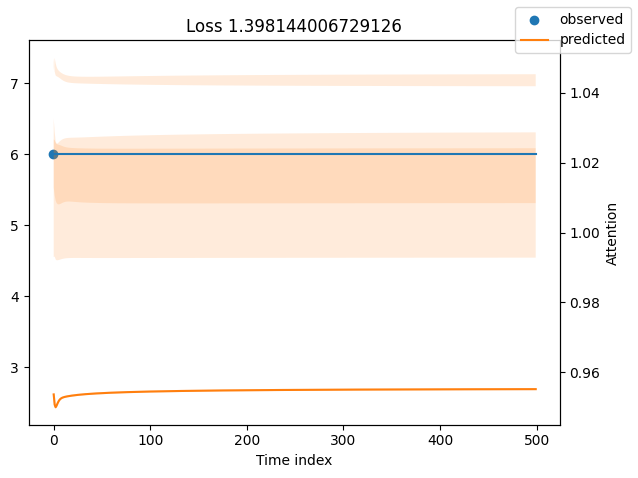

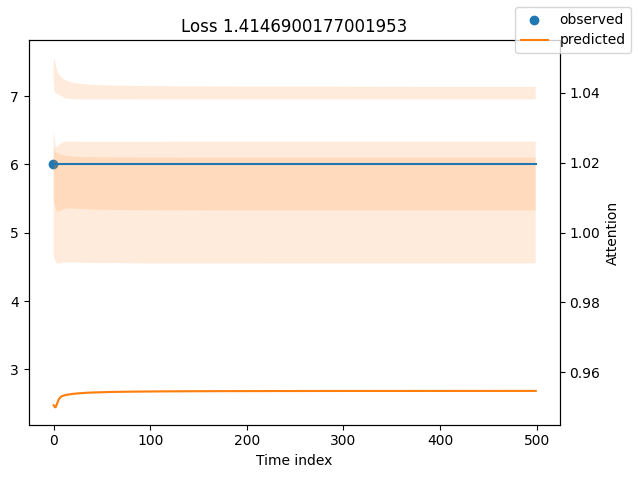

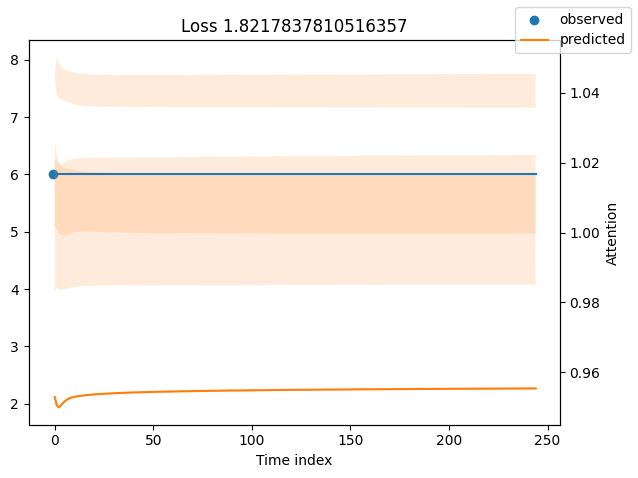

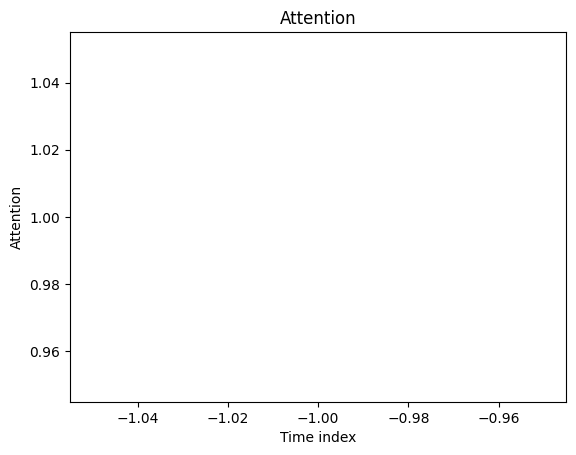

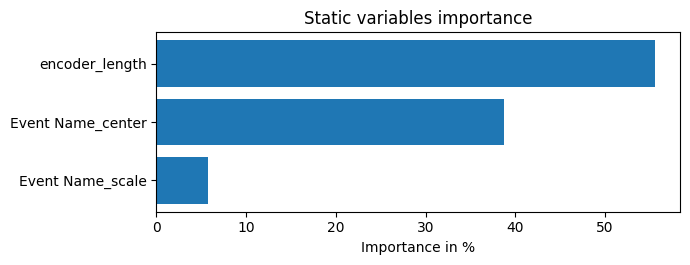

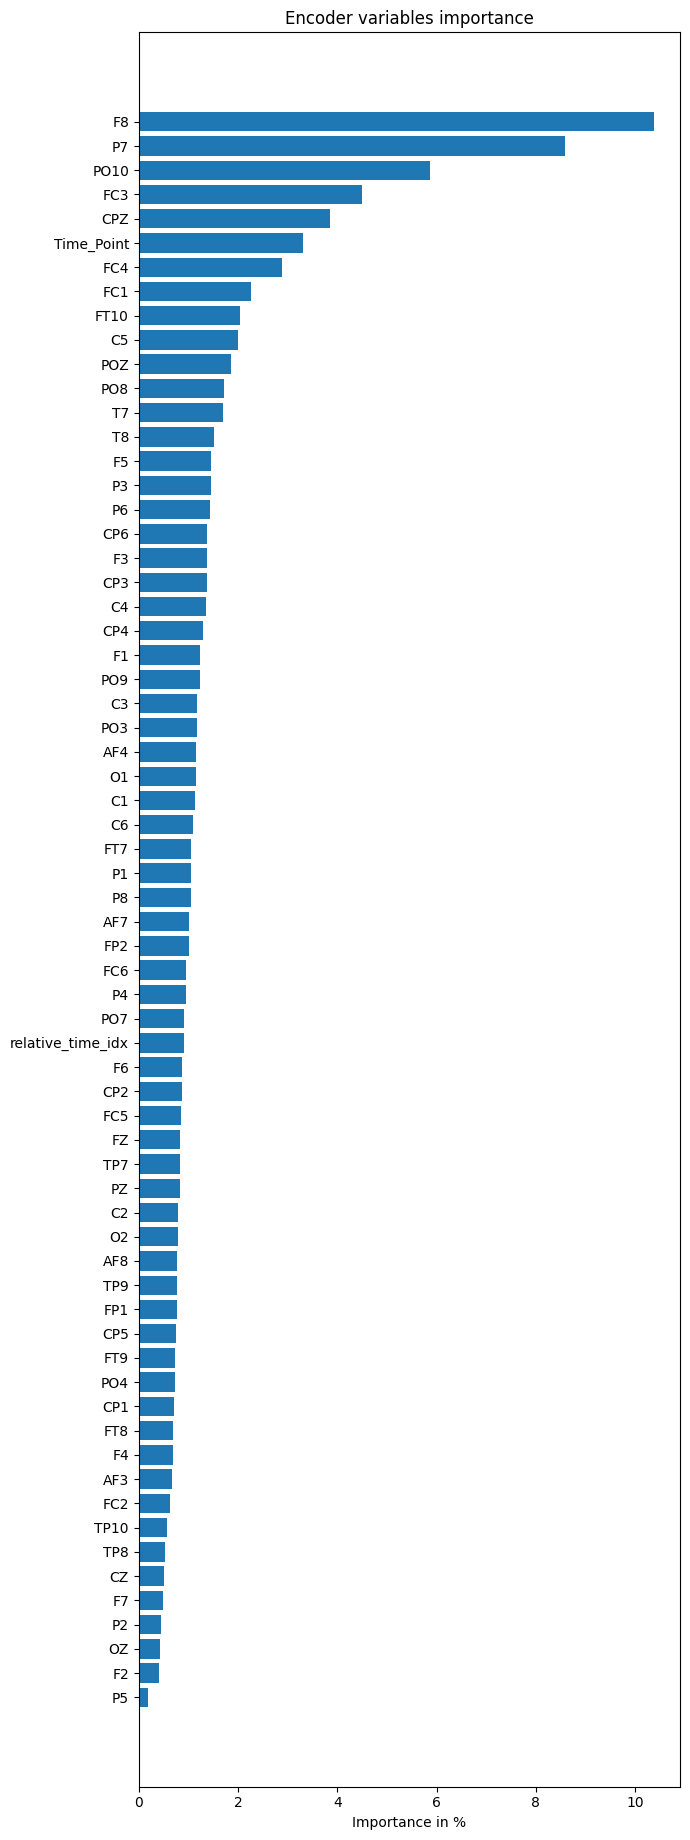

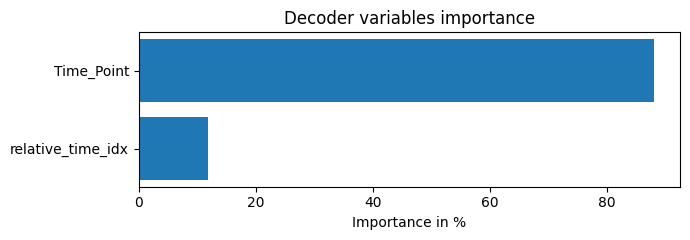

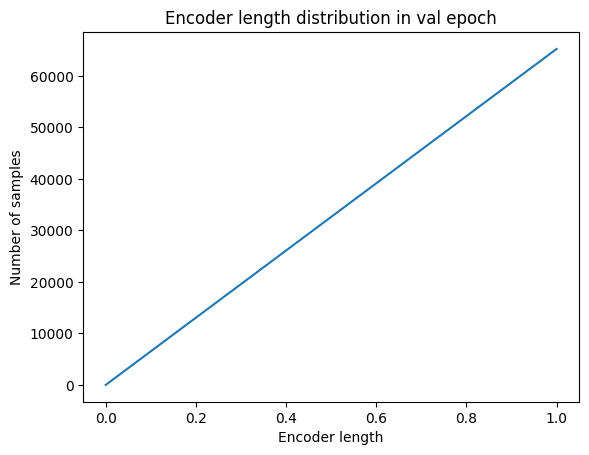

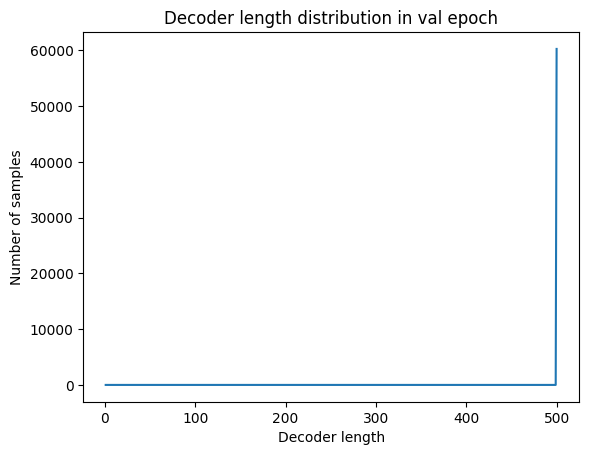

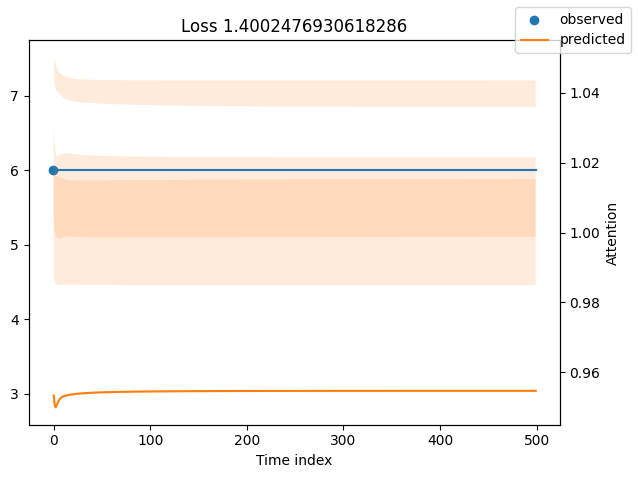

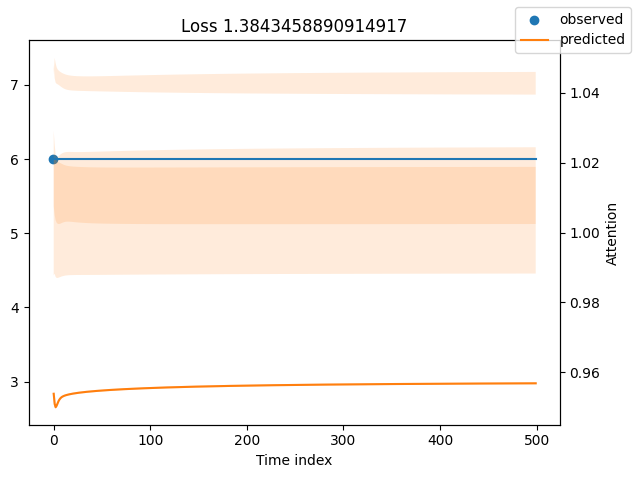

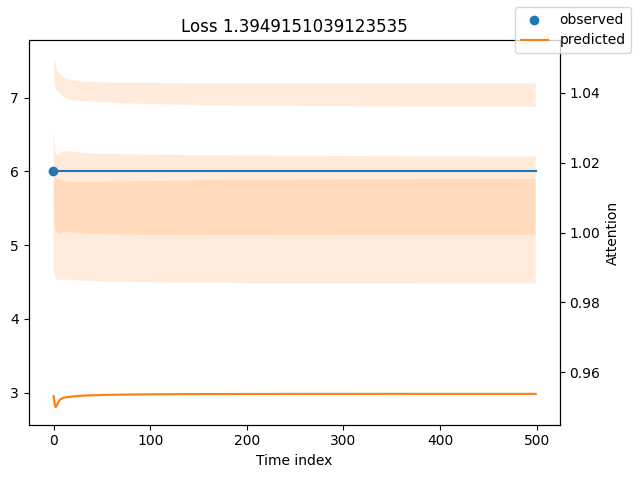

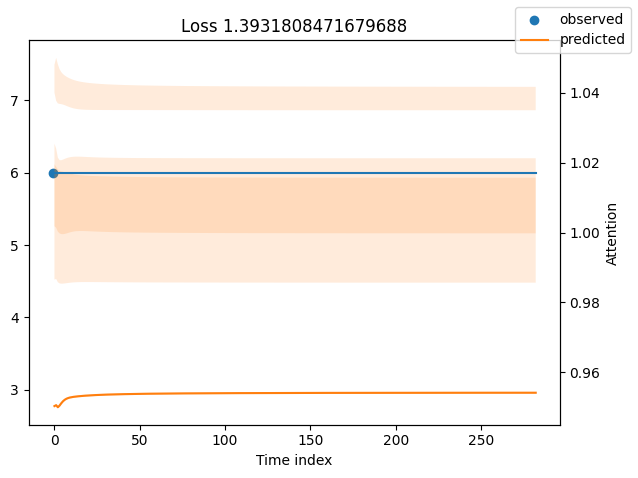

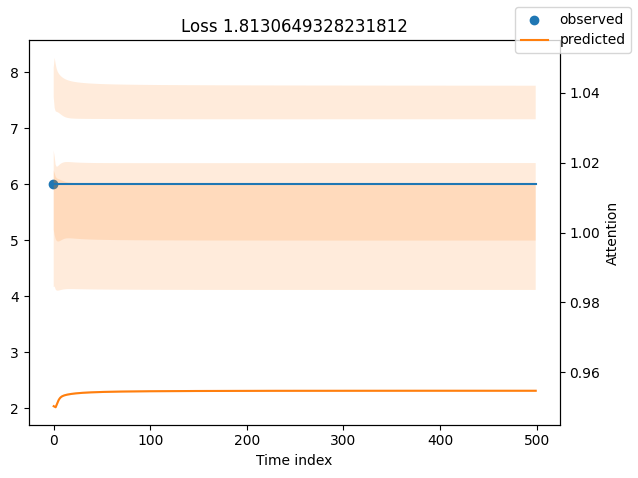

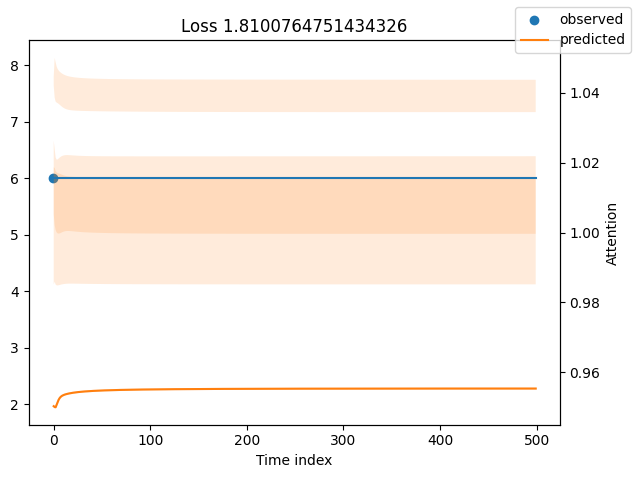

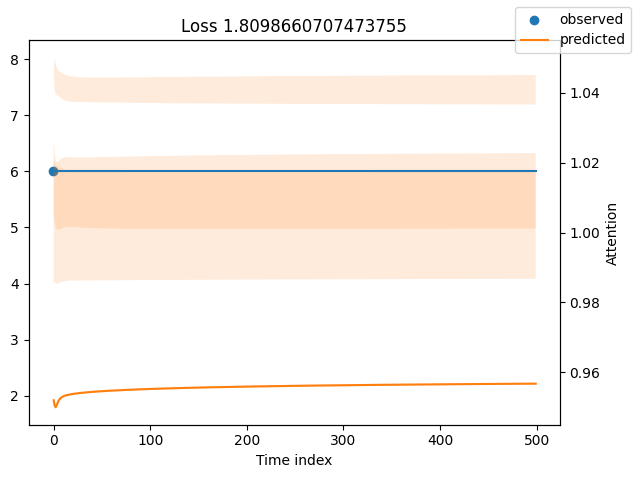

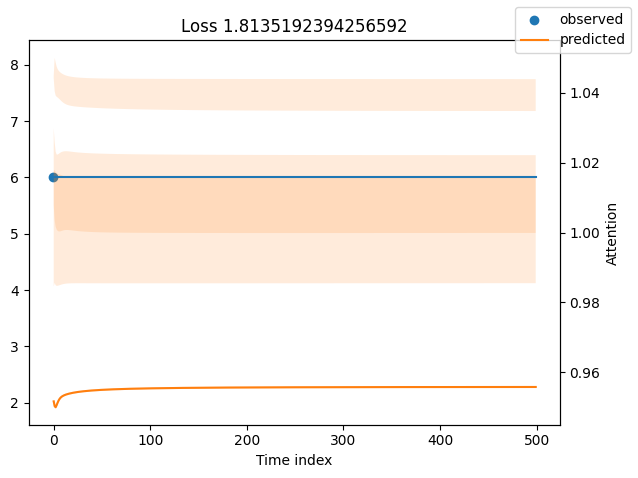

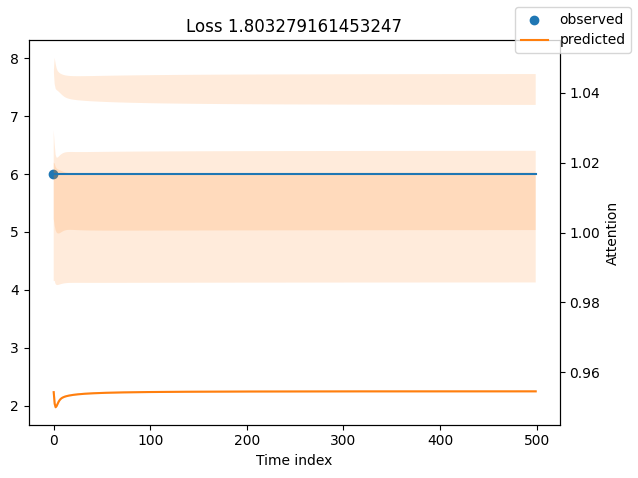

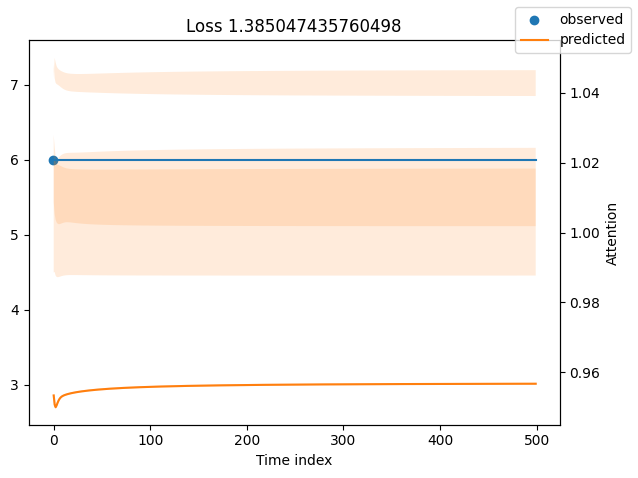

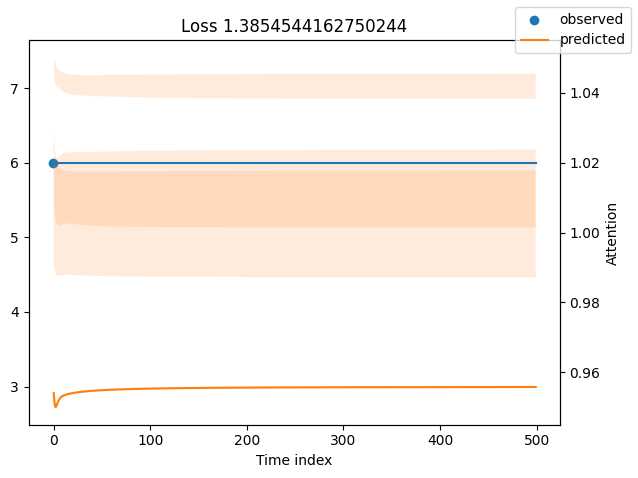

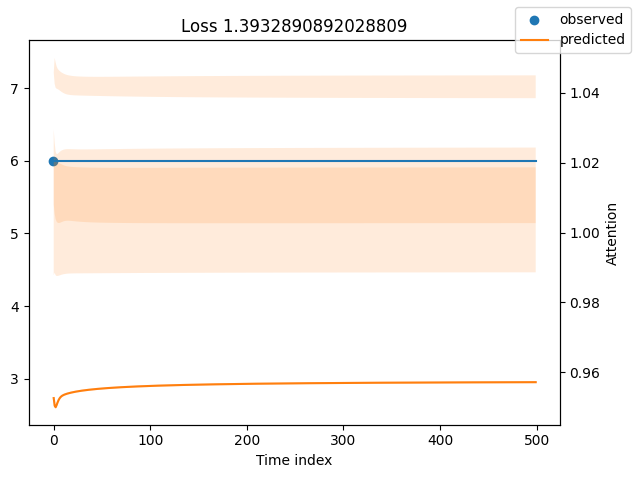

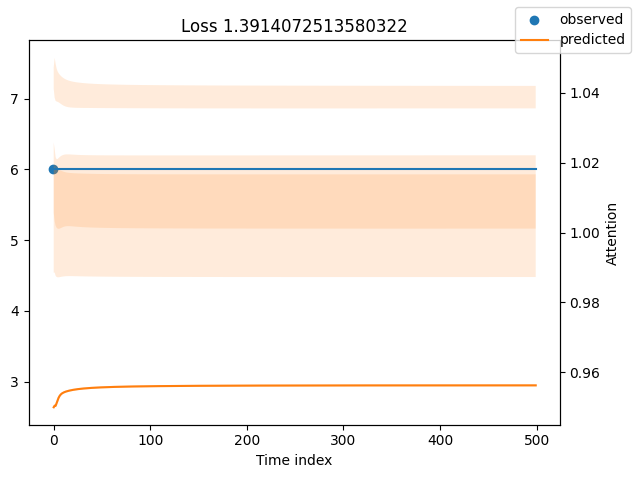

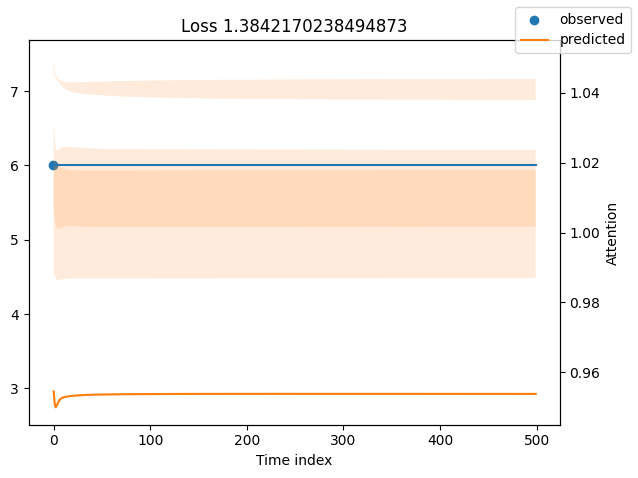

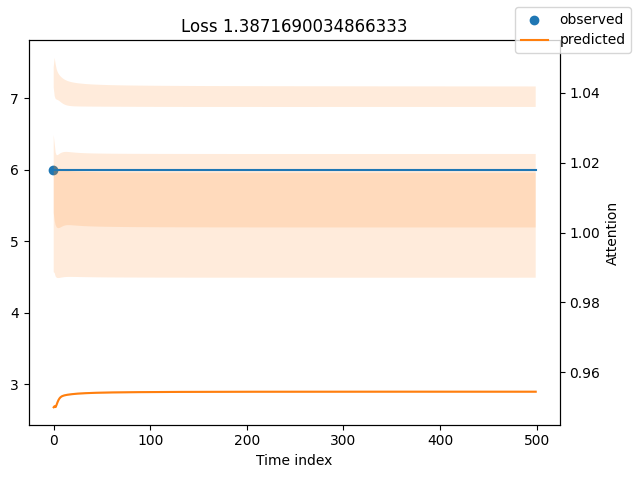

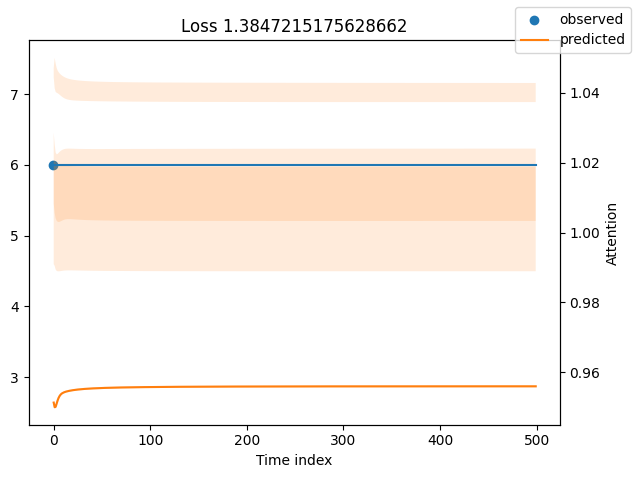

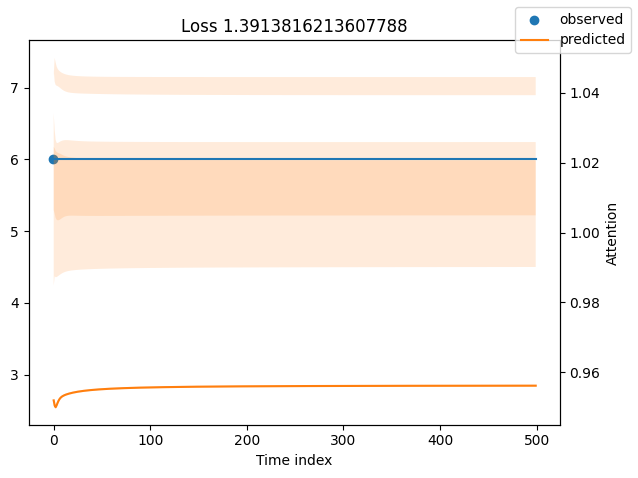

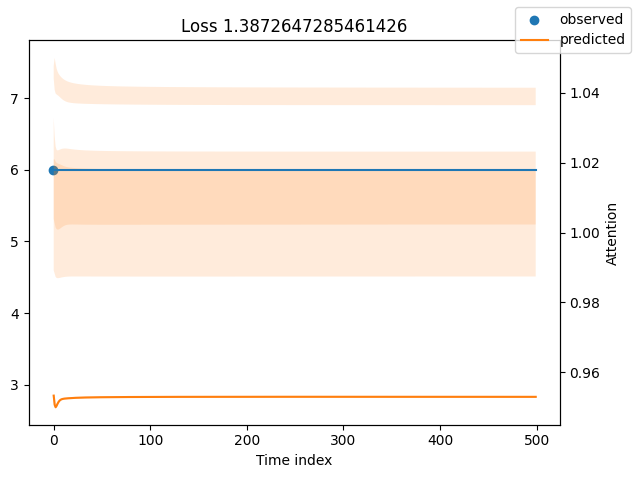

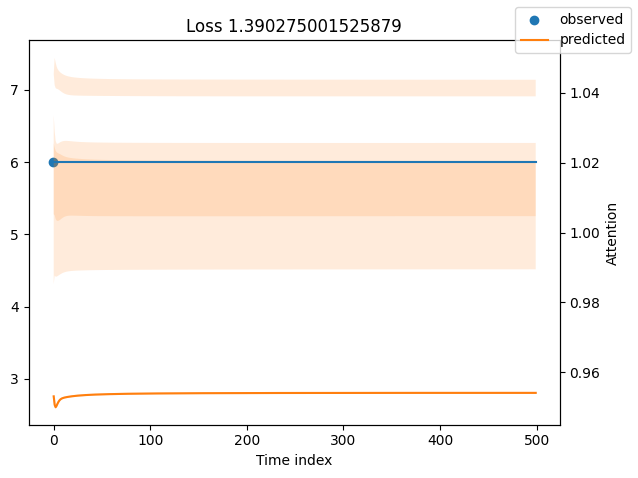

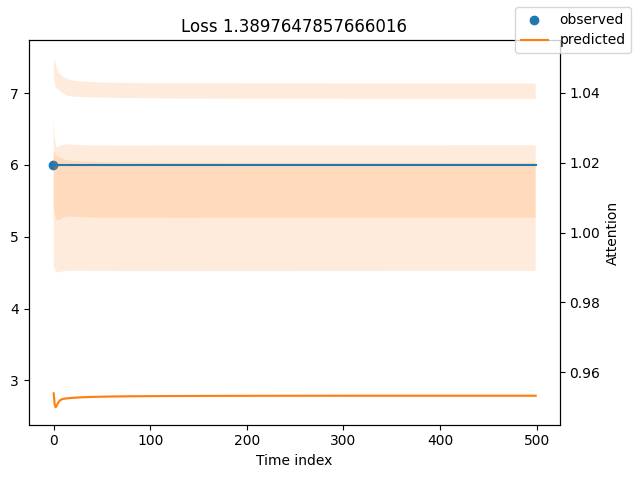

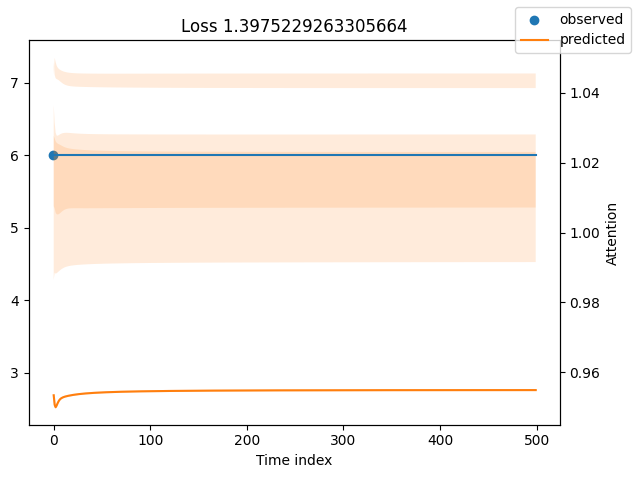

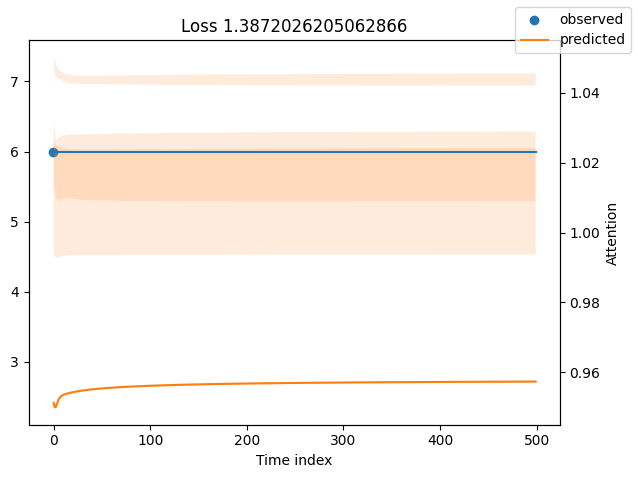

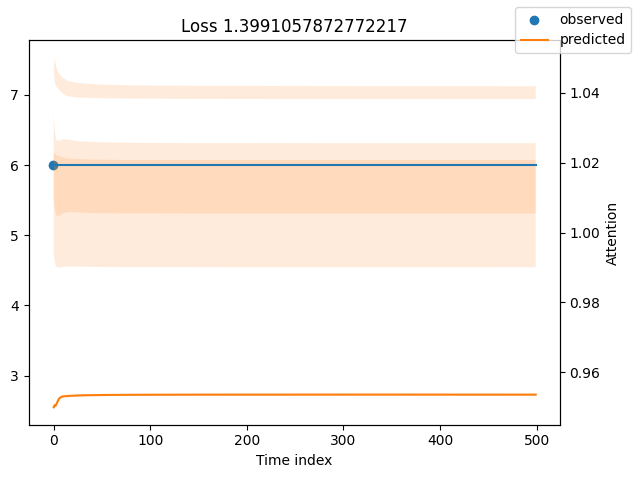

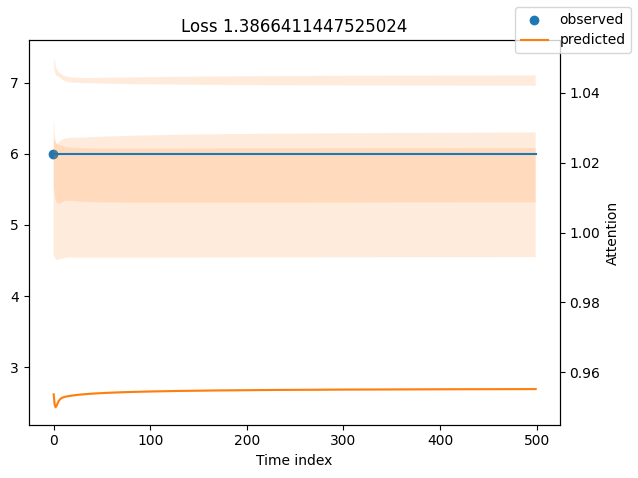

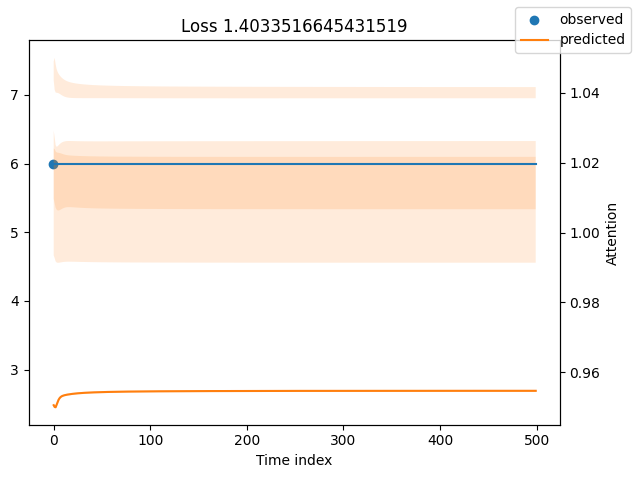

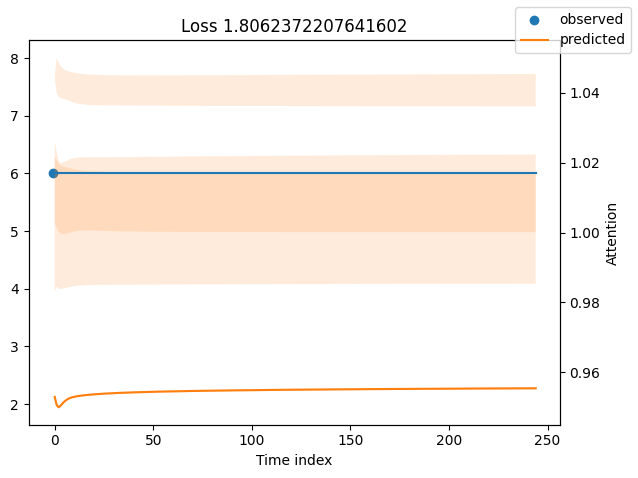

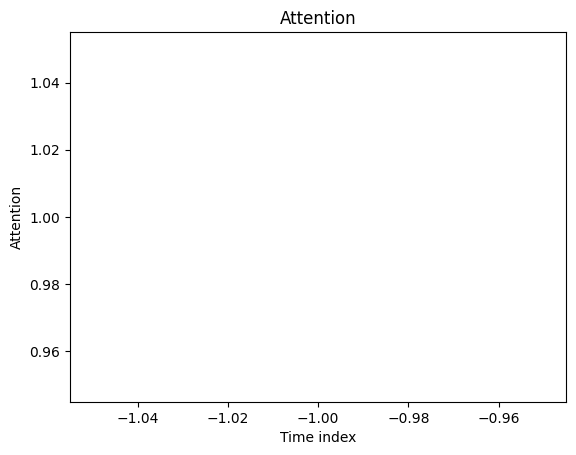

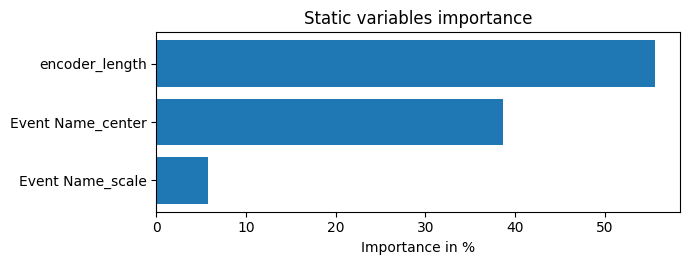

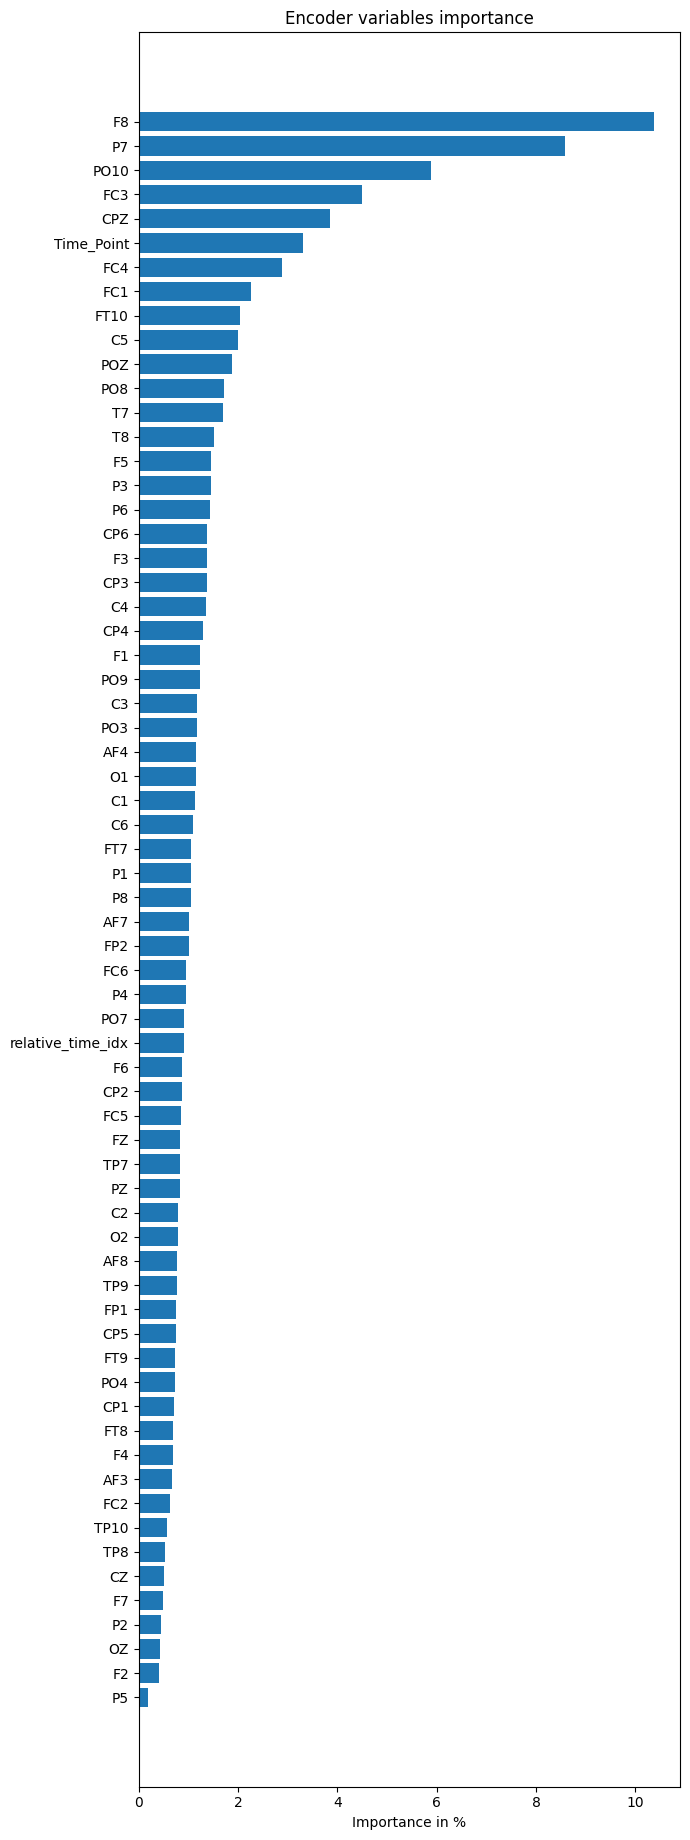

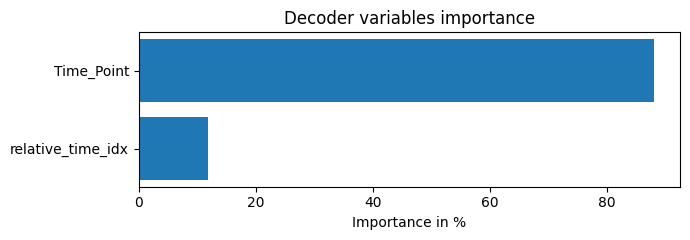

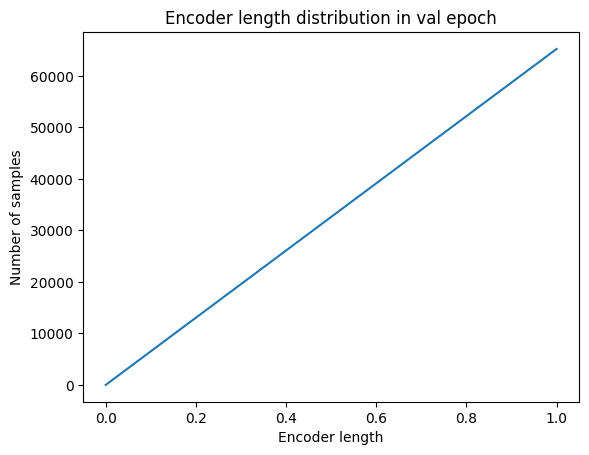

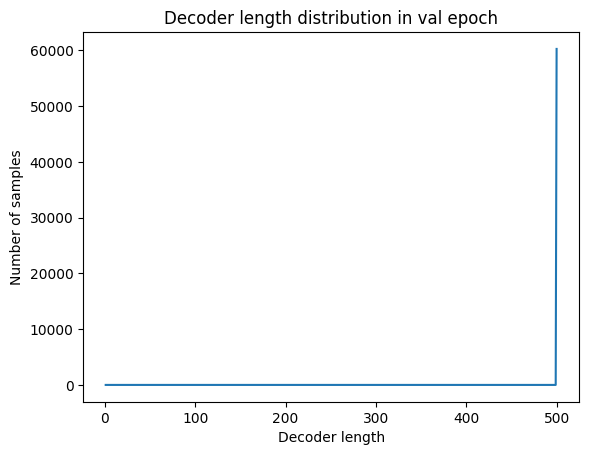

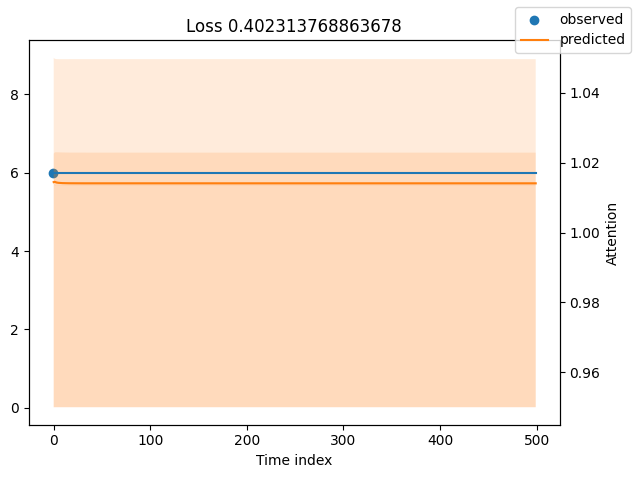

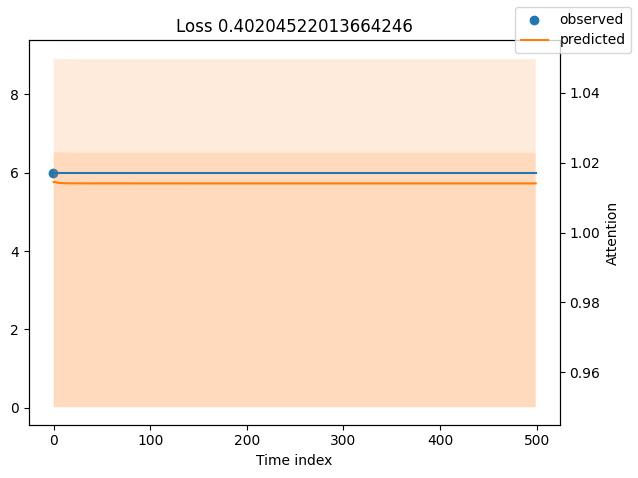

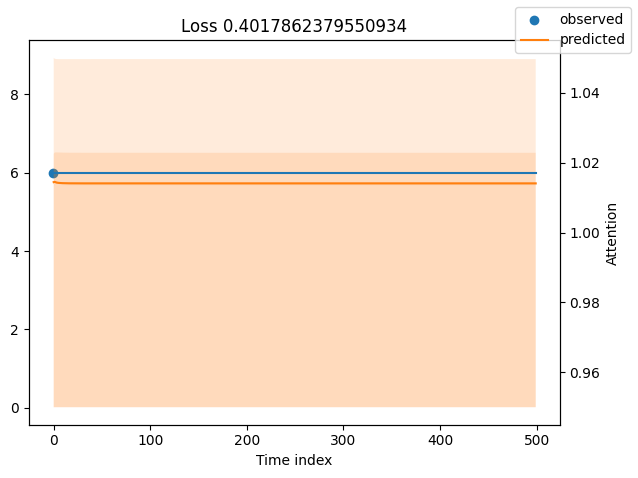

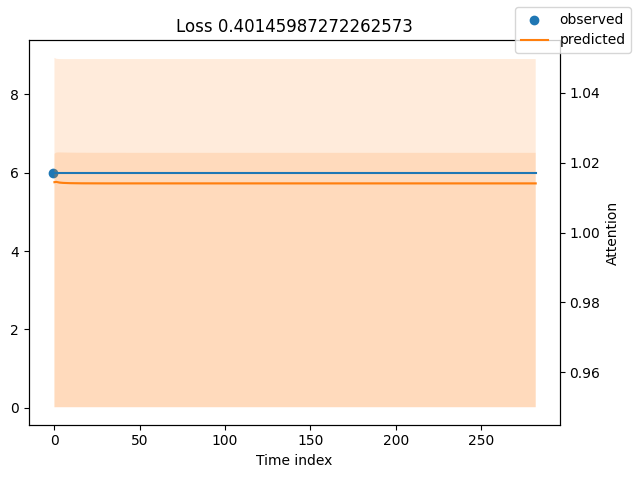

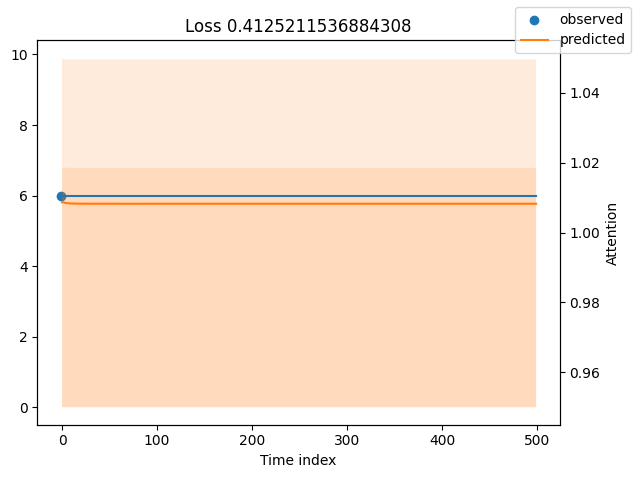

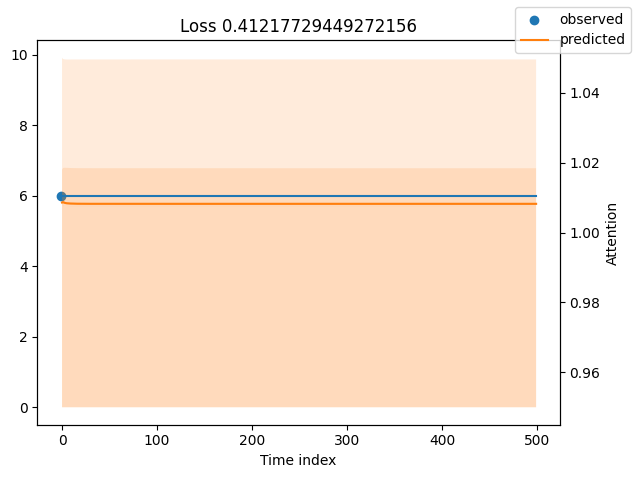

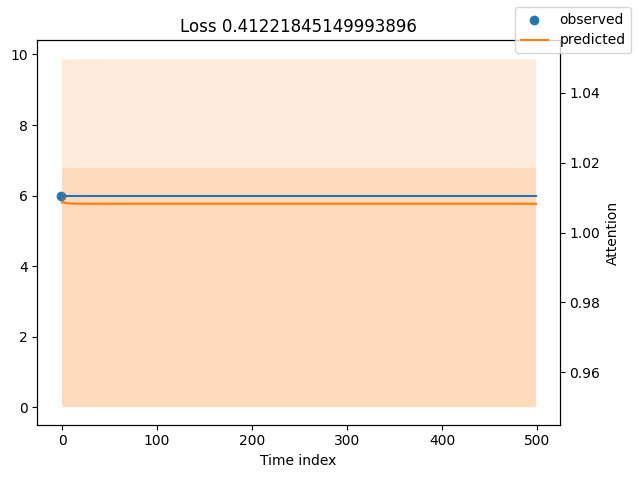

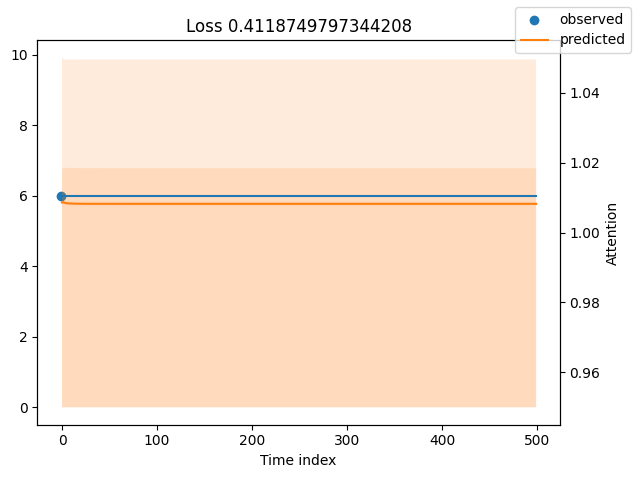

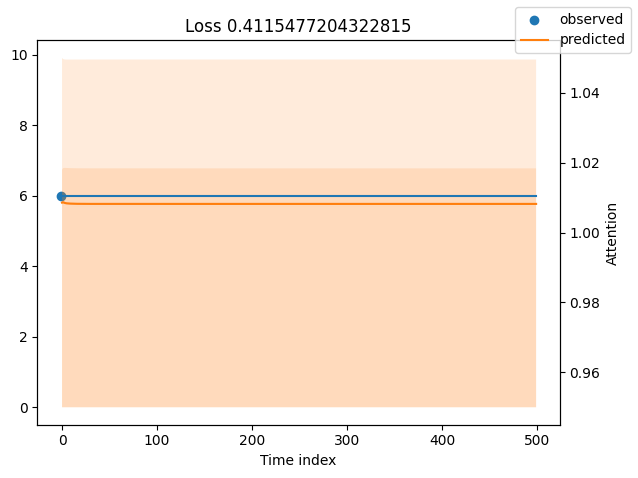

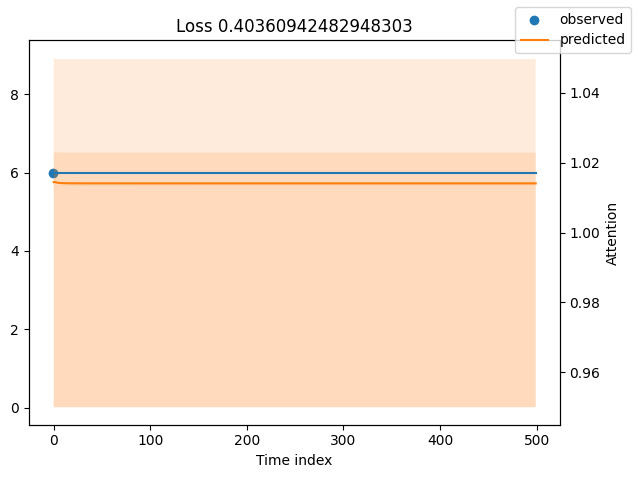

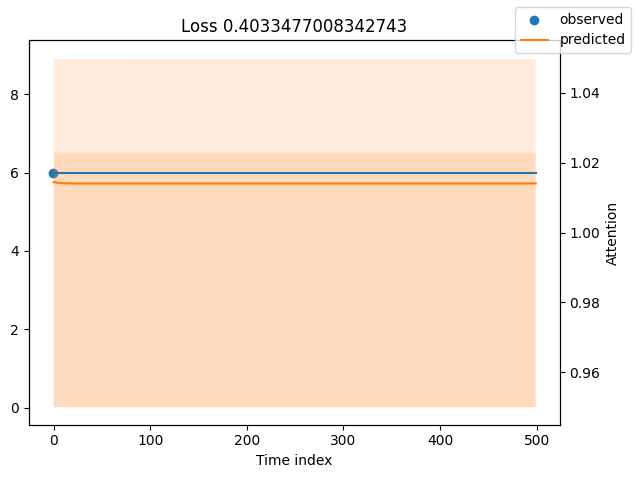

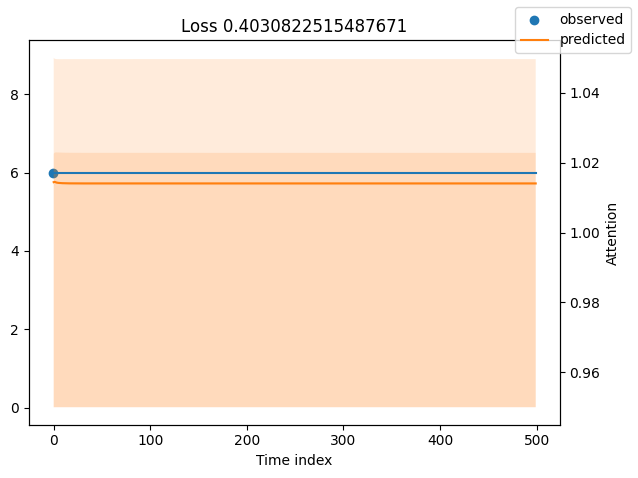

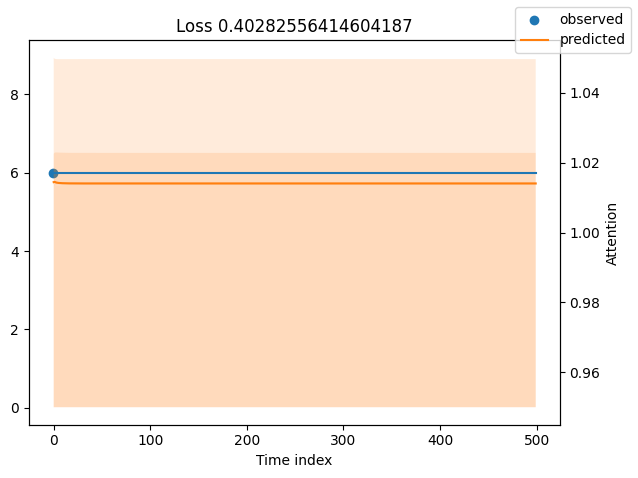

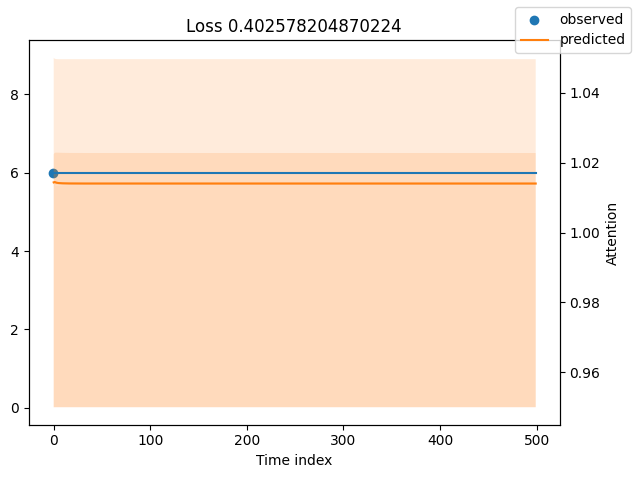

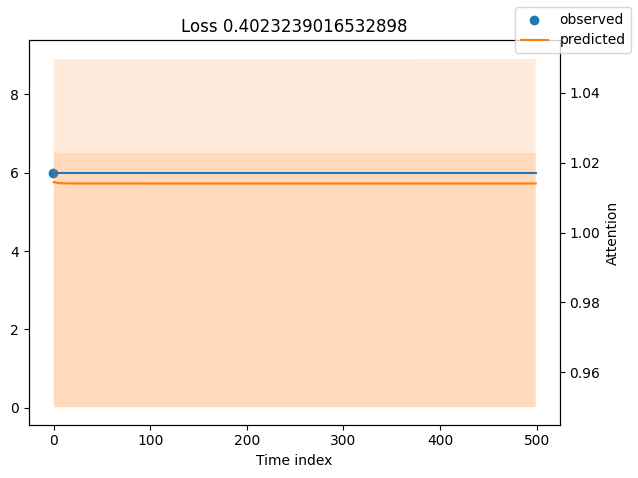

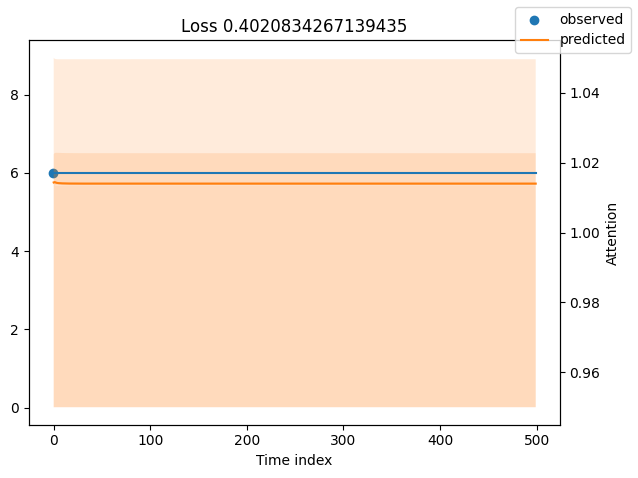

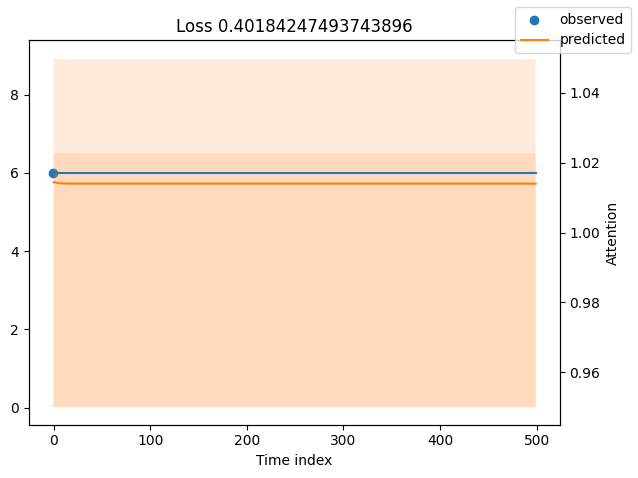

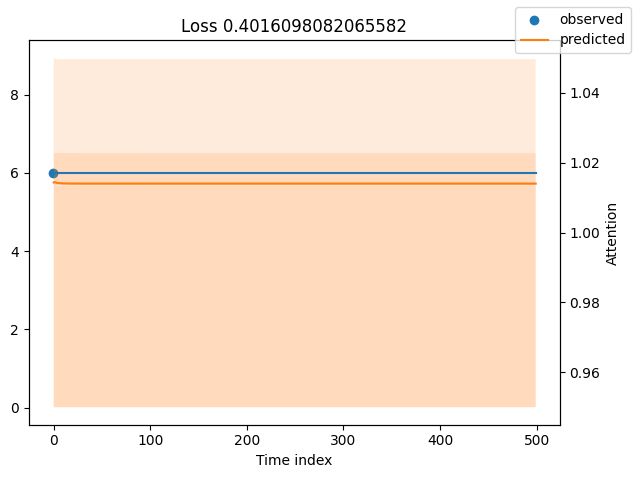

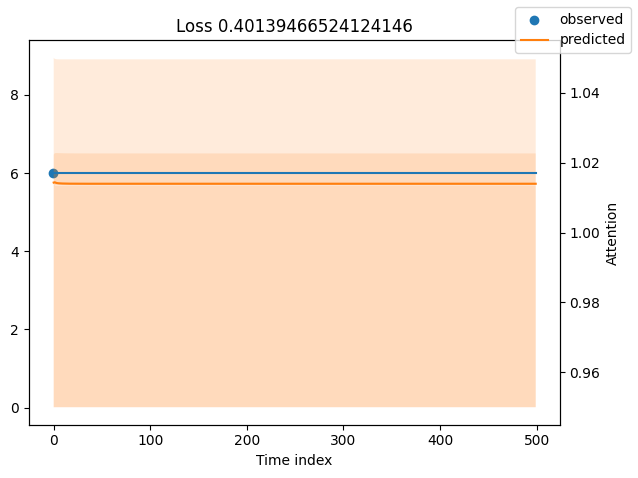

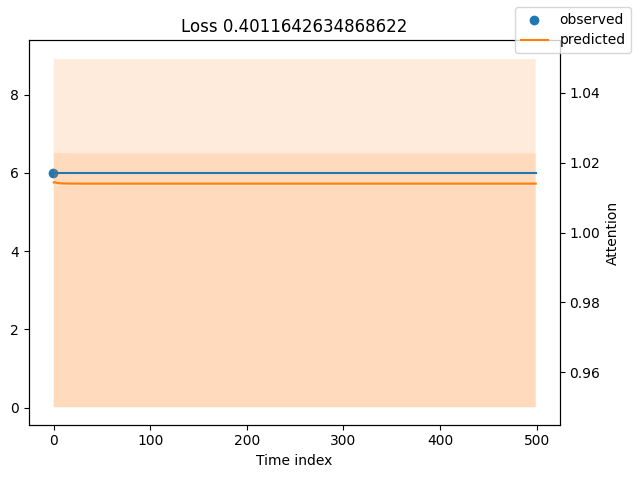

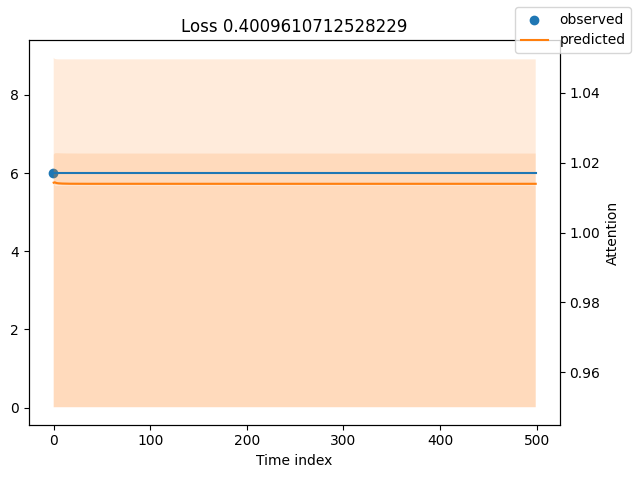

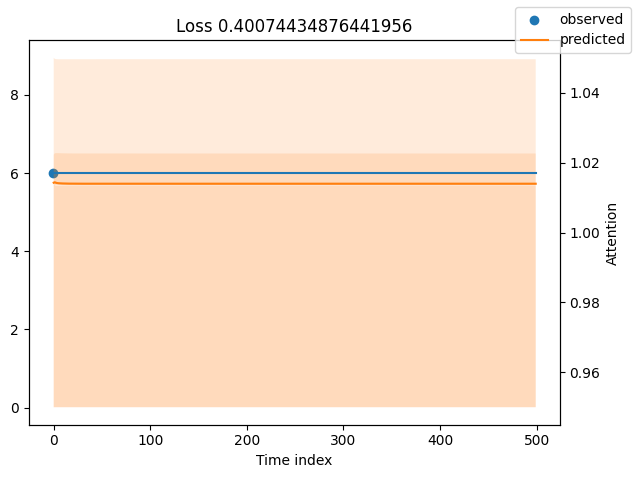

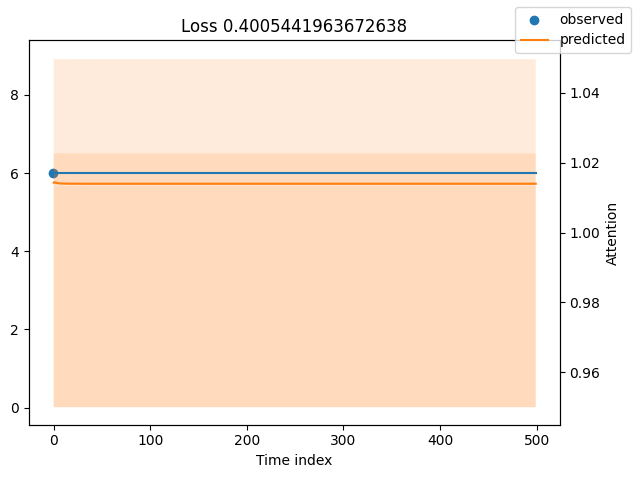

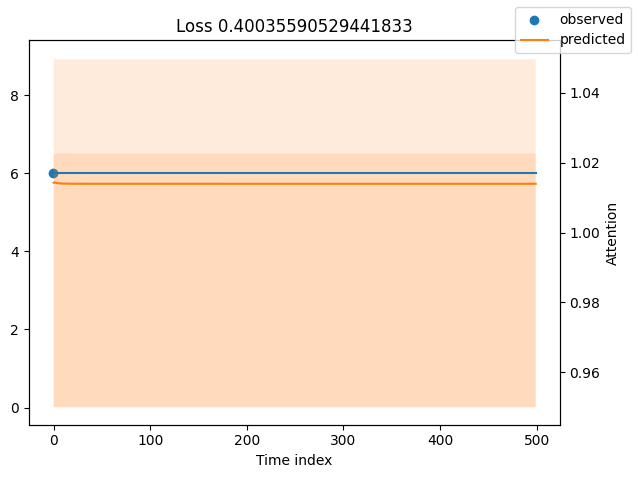

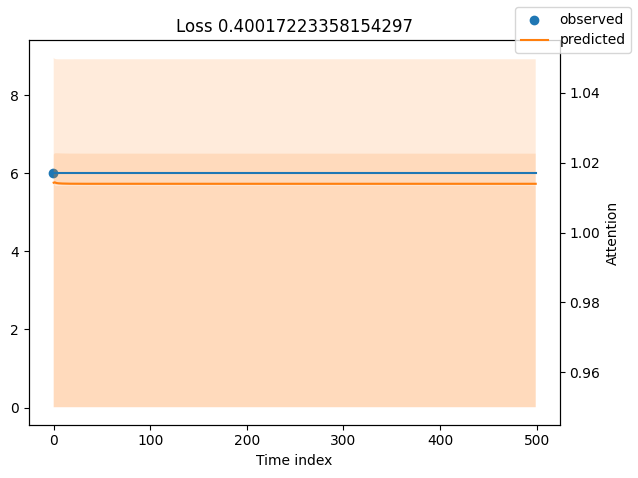

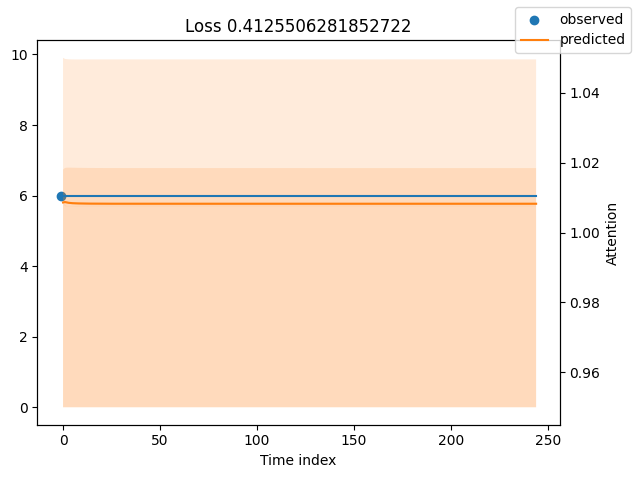

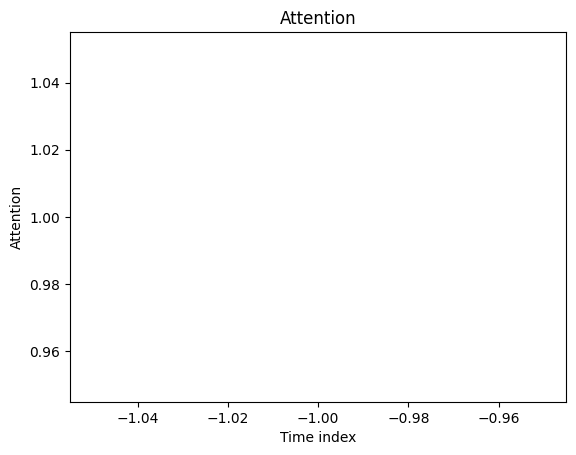

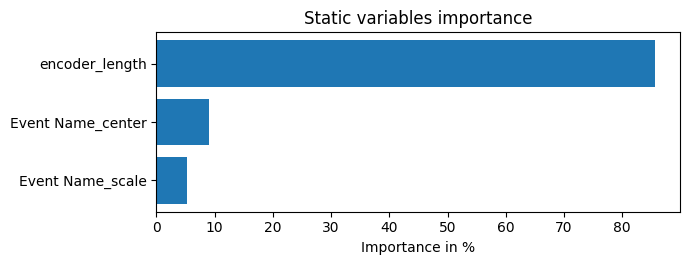

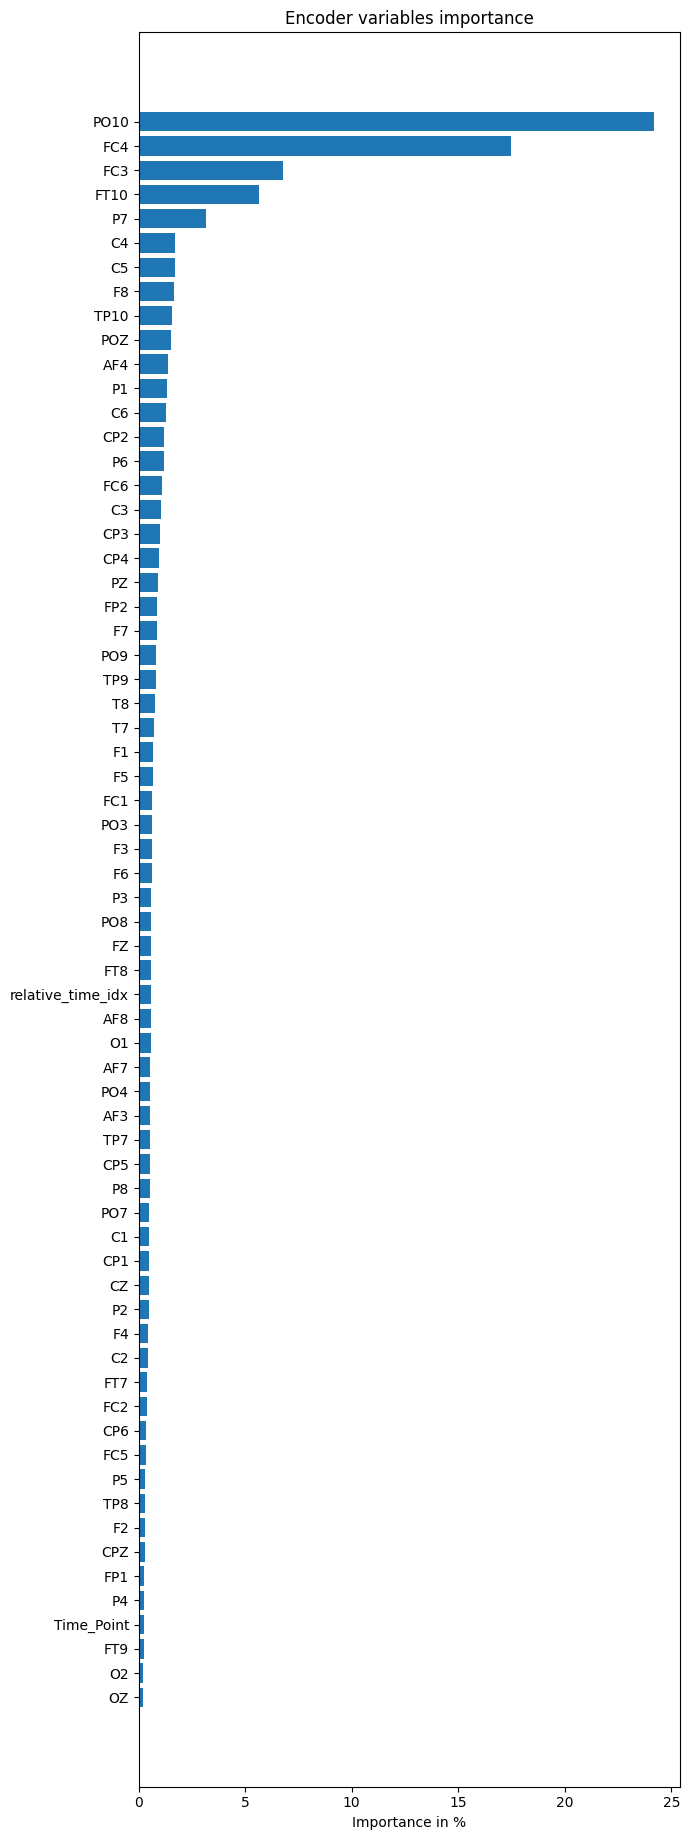

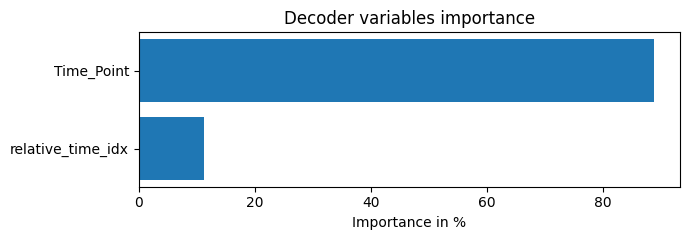

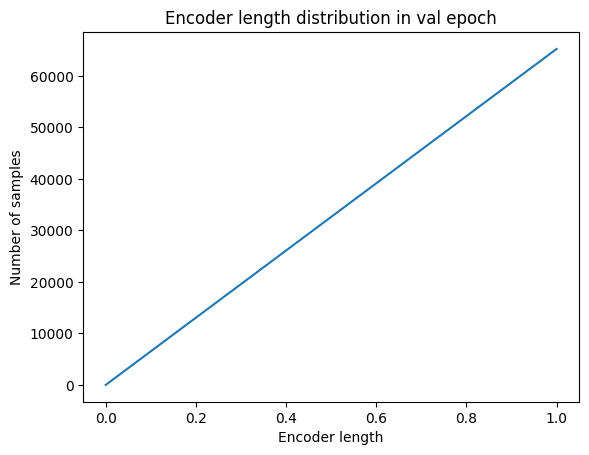

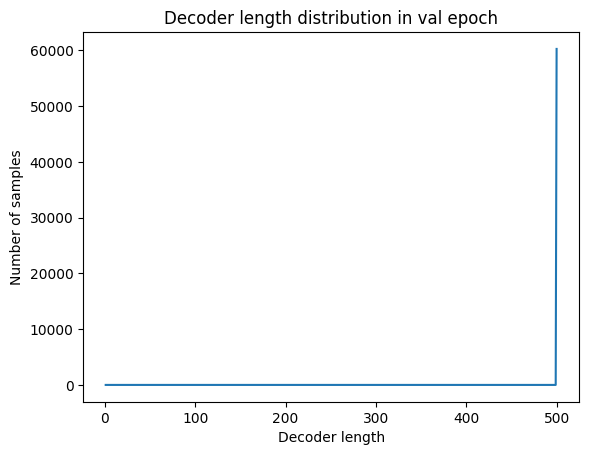

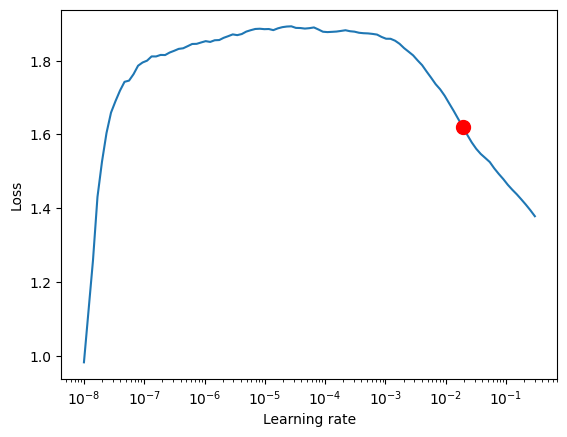

In [7]:
# find the optimal learning rate
res = Tuner(trainer).lr_find(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, early_stop_threshold=1000.0, max_lr=0.3,
)
# and plot the result - always visually confirm that the suggested learning rate makes sense
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [8]:
# fit the model on the data - redefine the model with the correct learning rate if necessary
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 2.2 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 5.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 160 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.8 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 4.3 

Epoch 0: 100%|█| 50/50 [01:40<00:00,  2.01s/it, v_num=27, train_loss_step=0.577]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [06:11<00:07,  7.43s/it]
Epoch 0: 100%|█| 50/50 [08:04<00:00,  9.70s/it, v_num=27, train_loss_step=0.577,
Epoch 1: 100%|█| 50/50 [01:41<00:00,  2.03s/it, v_num=27, train_loss_step=0.603,
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  76%|█████████████▊    | 39/51 [05:08<01:34,  7.90s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [06:32<00:07,  7.85s/it]
Epoch 1: 100%|█| 50/50 [08:27<00:00, 10.15s/it, v_num=27, train_loss_step=0.603,
Epoch 2: 100%|█| 50/50 [01:40<00:00,  2.01s/it, v_num=27, train_loss_step=0.589,
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [06:38<00:07,  7.97s/it]
Epoch 2: 100%|█| 50/50 [08:31<00:00, 10.23s/it, v_num=27, train_loss_step=0.589,
Epoch 2: 100%|█| 50/50 [08:32<00:00, 10.24s/it, v_num=27, train_loss_step=0.589,


In [9]:
# Save the model
trainer.save_checkpoint("/Users/zhezhengren/Desktop/NeuroPrior_AI/Model_Competion/EEG/Model/Transformer_test.ckpt")

In [10]:
# Load the model from the checkpoint
model = TemporalFusionTransformer.load_from_checkpoint("/Users/zhezhengren/Desktop/NeuroPrior_AI/Model_Competion/EEG/Model/Transformer_test.ckpt")

# Run the validation loop
validation_results = trainer.validate(model, dataloaders=val_dataloader)

# Print the validation results
print(validation_results)

Validation DataLoader 0: 100%|██████████████████| 51/51 [06:55<00:00,  8.14s/it]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_MAE          │    0.40539097785949707    │
│         val_MAPE          │        32062986.0         │
│         val_RMSE          │    0.6824793219566345     │
│         val_SMAPE         │    0.12104042619466782    │
│         val_loss          │    0.2387649267911911     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.2387649267911911, 'val_SMAPE': 0.12104042619466782, 'val_MAE': 0.40539097785949707, 'val_RMSE': 0.6824793219566345, 'val_MAPE': 32062986.0}]
